In [220]:
import os
import sys
sys.path.insert(0,os.path.join('/project/venv/vit_xai/lib/python3.8/site-packages/'))

In [221]:
os.environ

environ{'SHELL': '/bin/bash',
        'JUPYTERHUB_API_TOKEN': '614d11864abf4398b6913c922b09ac36',
        'PY_VERSION': '3.8',
        'JUPYTERHUB_BASE_URL': '/jupyter/n11-04/',
        'NCCL_VERSION': '2.16',
        'PWD': '/home/vijayach',
        'TRT_VERSION': '8.5',
        'JUPYTERHUB_SERVER_NAME': '',
        'HOME': '/home/vijayach',
        'CUDNN_PATH': '/usr/local/cuda-11.8/cudnn-8.7',
        'LANG': 'en_US.UTF-8',
        'JPY_API_TOKEN': '614d11864abf4398b6913c922b09ac36',
        'JUPYTERHUB_SERVICE_PREFIX': '/jupyter/n11-04/user/vijayach/',
        'TRT_PATH': '/usr/local/cuda-11.8/tensorRT-8.5',
        'JUPYTERHUB_OAUTH_CALLBACK_URL': '/jupyter/n11-04/user/vijayach/oauth_callback',
        'PYTHONPATH': '/scratch/vijayach/python/lib/python3.8/site-packages:/usr/local/cuda-11.8/tensorRT-8.5/lib/python3.8/dist-packages:/usr/local/jupyter/lib/python3.8/site-packages',
        'CPLUS_INCLUDE_PATH': '/scratch/vijayach/python/include:/usr/local/cuda-11.8/include:/usr/local

In [222]:
sys.path

['/project/venv/vit_xai/lib/python3.8/site-packages/',
 '/project/venv/vit_xai/lib/python3.8/site-packages/',
 '/project/venv/vit_xai/lib/python3.8/site-packages/',
 '/project/experiments',
 '',
 '/scratch/vijayach/python/lib/python3.8/site-packages',
 '/usr/local/cuda-11.8/tensorRT-8.5/lib/python3.8/dist-packages',
 '/usr/local/jupyter/lib/python3.8/site-packages',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/jupyter/lib/python3.8/site-packages/IPython/extensions',
 '/home/vijayach/.ipython']

In [223]:
!nvidia-smi

Sun Sep  1 18:35:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     Off | 00000000:03:00.0 Off |                    0 |
|  0%   23C    P8              20W / 300W |      4MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [224]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

# Import libraries

In [225]:
import numpy as np
from matplotlib import pyplot as plt
from transformers import TFViTForImageClassification, ViTImageProcessor
import tensorflow as tf
from datasets import load_dataset
from skimage.util import view_as_blocks
from numpy.linalg import norm
from itertools import combinations
import shutil
import itertools
import time, os
import pandas as pd
import csv

# Load data

In [226]:
val_data = load_dataset("frgfm/imagenette", "full_size", trust_remote_code=True,split='validation')

In [227]:
val_data.shuffle()

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

# Get concepts

In [228]:
concepts = [[],[],[],[],[],[],[],[],[],[]]
labels = []
n_examples = 20

for item in val_data:
    if np.array(item['image']).shape[-1]==3: # only look at images with 3 channels
        if (item['label']==0) & (len(concepts[0])<n_examples): #"tench"       # get the correct label
            labels.append(0)
            concepts[0].append([np.array(item['image']),item['label']])
        elif (item['label']==1) & (len(concepts[1])<n_examples): #"English springer"
            labels.append(217)
            concepts[1].append([np.array(item['image']),item['label']])
        elif (item['label']==2) & (len(concepts[2])<n_examples): #"cassette player"
            labels.append(482)
            concepts[2].append([np.array(item['image']),item['label']])
        elif (item['label']==3) & (len(concepts[3])<n_examples): #"chain saw"
            labels.append(491)
            concepts[3].append([np.array(item['image']),item['label']])
        elif (item['label']==4) & (len(concepts[4])<n_examples): #"church"
            labels.append(497)
            concepts[4].append([np.array(item['image']),item['label']])
        elif (item['label']==5) & (len(concepts[5])<n_examples): #"French horn"
            labels.append(566)
            concepts[5].append([np.array(item['image']),item['label']])
        elif (item['label']==6) & (len(concepts[6])<n_examples): #"garbage truck"
            labels.append(569)
            concepts[6].append([np.array(item['image']),item['label']])
        elif (item['label']==7) & (len(concepts[7])<n_examples): # "gas pump"
            labels.append(571)
            concepts[7].append([np.array(item['image']),item['label']])
        elif (item['label']==8) & (len(concepts[8])<n_examples): # "golf ball"
            labels.append(574)
            concepts[8].append([np.array(item['image']),item['label']])
        elif (item['label']==9) & (len(concepts[9])<n_examples): #"parachute"
            labels.append(701)
            concepts[9].append([np.array(item['image']),item['label']])

In [231]:
def print_examples(concept):
  for i in range(0,20):
    plt.subplot(1,20,i+1)
    plt.imshow(concept[i][0])
    plt.axis("off")

#   plt.tight_layout()
  plt.show()

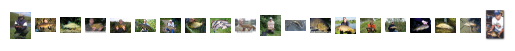

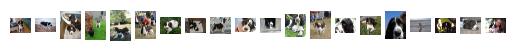

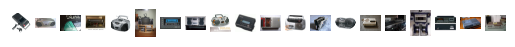

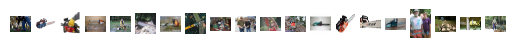

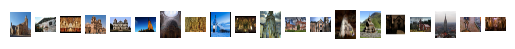

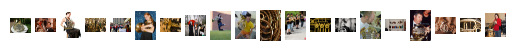

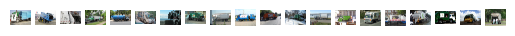

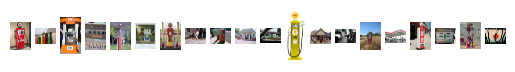

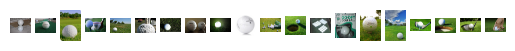

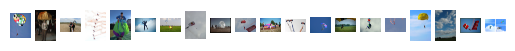

In [232]:
# for each class take the first n_examples images to form concept
for concept in concepts:
    print_examples(concept)

# Load pretrained model

In [12]:
model = TFViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

image_processor = ViTImageProcessor()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

2024-08-14 17:56:37.548452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:03:00.0, compute capability: 8.6
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [13]:
model.summary(expand_nested=True)

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  769000    
                                                                 
Total params: 86567656 (330.23 MB)
Trainable params: 86567656 (330.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
print(model.config)

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "15": "robin, American robin, Turdus migratorius",
    "16": "bulbul",
 

# Concept embeddings

In [15]:
#  average the embedding for a concept -> concept embedding
def average_embedding(embedding):
    embedding = embedding.numpy() # (20, 197, 768)
    embedding = embedding[:,1:,:] # drop CLS -> (20, 196, 768)
    embedding = embedding.mean(axis=0) # mean over batch
    embedding = embedding.mean(axis=0) # mean over patches
    # embedding (768,)
    
    return embedding

# embedding of one example image of a concept
def image_embedding(embedding):
    embedding = embedding.numpy() # (197, 768)
    embedding = embedding[1:,:] # drop CLS -> (196, 768)
    embedding = embedding.mean(axis=0) # mean over patches
    # embedding (768,)
    
    return embedding


# average the embedding for a concept -> concept embedding, only using k most relevant patches
def average_embedding_top_k(embedding, k, relevances, modus):
    # embedding (20, 197, 768) 
    # relevances  (20,196)
    
    avg = []
    for i, relevance in enumerate(relevances): # relevance: (196,) -> relevances are for all examples of a concept; i--> ith image of a concept
        # take only k most important patches
        if modus == "top": # normal top-k selection
            _, indices = tf.math.top_k(relevance, k=k, sorted=True)
        elif modus == "bottom": # flipped top-k selection
            _, indices = tf.math.top_k(-1*relevance, k=k, sorted=True)
        elif modus == "random": # random selection
            indices = tf.random.uniform(shape=(30,), minval=0,maxval=195, dtype=tf.int64)
        else:
            raise "Modus not supported"
        
        indices = indices.numpy() # (30,)
        intermediate = embedding[i,1:,:].numpy() # (197, 768) # take embedding of ith example corresponding to relevance, remove CLS
        intermediate = tf.gather(intermediate, indices).numpy() # take only top-k patches -> (30, 768)
        intermediate = np.array(intermediate.mean(axis=0)) # mean over patches -> (768,)
        avg.append(intermediate)  # avg embedding of image
    avg = np.array(avg).mean(axis=0) # mean over examples (20, 768) -> (768,) avg embedding of whole concept

    return avg

# embedding of one example image of a concept only using top k most relevant patches
def image_embedding_top_k(embedding, k, relevances, modus):
    # embedding (197, 768) 
    # relevances  (196)
    
    # take only k most important patches
    if modus == "top": # normal top-k selection
        _, indices = tf.math.top_k(relevances, k=k, sorted=True)
    elif modus == "bottom": # flipped top-k selection
        _, indices = tf.math.top_k(-1*relevances, k=k, sorted=True)
    elif modus == "random": # random selection
        indices = tf.random.uniform(shape=(30,), minval=0,maxval=195, dtype=tf.int64)
    else:
        raise "Modus not supported"
        
    indices = indices.numpy() # (30,)
    intermediate = embedding[1:,:].numpy() # (197, 768) #  remove CLS
    intermediate = tf.gather(intermediate, indices).numpy() # take only top-k patches -> (30, 768)
    intermediate = np.array(intermediate.mean(axis=0)) # mean over patches -> (768,)
    
    return intermediate

In [16]:
def get_embeddings_and_attentions(concepts_selected):
    # Get Input for the model wrt different concepts
    inputs = []
    for concept in concepts_selected:
        x_concept,_ = zip(*concept)
        inputs.append(image_processor(x_concept, return_tensors="tf").pixel_values)

    # make predictions
    preds = []
    for input in inputs:
        pred = model(input, output_hidden_states=True, output_attentions=True)
        preds.append(pred)


    # for each concept in concept_nums(4): for each layer (13): (20,197,768)
    embeddings_list = []
    # for each concept in concept_nums(4): for each layer (12): (20,12,197,197)
    attentions_list = []
    for pred in preds:
        embeddings_list.append(pred.hidden_states)
        attentions_list.append(pred.attentions)
        
    return embeddings_list, attentions_list


def get_embeddings(concepts):
    # Get Input for the model wrt different concepts
    inputs = []
    for concept in concepts:
        x_concept,_ = zip(*concept)
        inputs.append(image_processor(x_concept, return_tensors="tf").pixel_values)

    # make predictions
    preds = []
    for input in inputs:
        pred = model(input, output_hidden_states=True, output_attentions=True)
        preds.append(pred)


    # for each concept in concept_nums(4): for each layer (13): (20,197,768)
    embeddings_list = []

    for pred in preds:
        embeddings_list.append(pred.hidden_states)
        
    return embeddings_list

## Finding a scale for the distances

In [17]:
# for every concept (10), for every layer (13): (20,197,768)
embeddings_list_scales = get_embeddings(concepts)
scales = tf.norm(embeddings_list_scales, axis=-1) # (10,13,20,197)
scales = np.mean(scales, axis=-1) # (10,13,20)
scales = np.mean(scales, axis=-1) # (10,13)

2024-08-14 17:56:59.622648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-08-14 17:57:17.636551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [18]:
scales = np.mean(scales, axis=0) #(13,)
scales = scales[:12] # drop last layer (12,)
scales

array([ 18.701006,  28.89441 ,  33.028004,  38.943657,  44.178913,
        58.104755, 106.806015, 148.57896 , 160.6914  , 172.56763 ,
       193.47894 , 248.25833 ], dtype=float32)

## Patch selection

In [19]:
k = 50
concept_nums = np.array([0,1,2,3,4,5,6,7,8,9])
concepts_selected = [concepts[i] for i in concept_nums]
layer_num = 0

embeddings_list, attentions_list = get_embeddings_and_attentions(concepts_selected)


# for each concept in concept_nums (4): for each layer (13): avg embedding = 197 values
#avg_embeddings_list = []
#for embeddings in embeddings_list:
#  avg_embeddings_list.append(average_embedding(embeddings[layer_num]))

### Attention Rollout

In [20]:
#https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py

def rollout(attentions, discard_ratio, head_fusion, layer_num):
  # attentions: for 12 layers: (20, 12, 197, 197) = (batch_size, n_heads, sequence_len, sequence_len)
  result = tf.eye(attentions[0].shape[-1]) # result.shape=(197,197), attentions[0].shape (1, 12, 197, 197)
  for i, attention in enumerate(attentions[::-1]):
    if i + layer_num == 13: # do rollout only until specified layer ------------------- 
        break
    if head_fusion == "mean":
      attention_heads_fused = attention.numpy().mean(axis=1)
    elif head_fusion == "max":
      attention_heads_fused = attention.numpy().max(axis=1)[0]
    elif head_fusion == "min":
      attention_heads_fused = attention.numpy().min(axis=1)#[0]
    else:
      raise "Attention head fusion type Not supported"

    # attention_heads_fused.shape -> (1,197,197)

    # Drop the lowest attentions, but
    # don't drop the class token
    flat = attention_heads_fused.reshape(attention_heads_fused.shape[0], -1) # flat.shape -> (1, 38809)
    _, indices = tf.math.top_k(flat, k=int(flat.shape[-1]*discard_ratio), sorted=False)
    indices = indices[indices != 0]
    flat[0, indices] = 0

    I = tf.eye(attention_heads_fused.shape[-1]) #I.shape -> (197,197)
    a = (attention_heads_fused + 1.0*I)/2
    a = a / tf.math.reduce_sum(a, -1)

    result = tf.matmul(a, result) # (1,197,197)

  # Look at the total attention between the class token,
  # and the image patches
  #print(result.shape)
  mask = result[0,0,1:]
    
  return mask.numpy()

In [21]:
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="max",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        #for name, module in self.model.named_modules():
           # if attention_layer_name in name:
               # module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor, layer_num):
        self.attentions = []
        output = self.model(input_tensor, output_attentions=True)

        return rollout(output.attentions, self.discard_ratio, self.head_fusion, layer_num)

### Relevances

#### Attention relevance - Class token in different layers

In [22]:
def get_attention_relevance(attentions, layer_num):
    # attentions --> (12, 20, 12, 197, 197) - attentions of all 20 images of a concept, across 12 layers, 12 heads, 197 tokens

    # basic attention: CLS at different layers
    # for each concept: attention of layer [0,11], mean over heads
    ## attentions[layer_num].numpy() --> extracting attention of a layer: (12, 20, 12, 197, 197) -> (20, 12, 197, 197)
    ## taking mean attention over all heads: (20, 12, 197, 197) -> (20, 197, 197
    att = attentions[layer_num].numpy().mean(axis=1)
    # attention from CLS token to all other patches
    att = att[:,0,1:] # Shape: (20, 196)
    
    return att # (20,196)



#### Attention relevance - Class token in different layers (with rollout)

In [23]:
def get_rollout_relevance(concept, model, layer_num):
    grad_rollout = VITAttentionRollout(model, head_fusion="mean", discard_ratio=0.01)
    x_concept,_ = zip(*concept)
    input = image_processor(x_concept, return_tensors="tf").pixel_values

    # for each example (20):  196 relevance values
    masks = []
    for i in range(len(concept)):
        mask = grad_rollout(input[i:i+1], layer_num)   # (196,)
        masks.append(mask)

    return masks

#### Attention relevance - Aggregated attention in different layers

In [24]:
def get_agg_attention_relevance(attentions_list, layer_num, aggregation_type='max'):
    # attentions_list --> (12, 20, 12, 197, 197) - attentions of all 20 images of a concept, across 12 layers, 12 heads, 197 tokens
    # aggregation types (max, min, mean)

    # Extract the attentions for the specific layer
    layer_attentions = attentions_list[layer_num].numpy()  # Shape: (20, 12, 197, 197)

    # Initialize array to store the attention relevance scores for each image
    agg_attention_relevances = np.zeros((layer_attentions.shape[0], layer_attentions.shape[2] - 1))  # Shape: (20, 196)

    # Iterate over each image in the batch
    for i in range(layer_attentions.shape[0]):
        # Extract the attention values for the current image, excluding the CLS token
        image_attentions = layer_attentions[i, :, 1:, 1:]  # Shape: (12, 196, 196) - 12 heads, 196 tokens (excluding CLS), 196 tokens (excluding CLS)

        # Calculate the aggregated attention over all heads for each token (excluding CLS token)
        # First, take the aggregated attention across the heads
        # Then, take the aggregated attention attention value for each token
        if aggregation_type == 'max':
            # Calculate the maximum attention over all heads for each token (excluding CLS token)
            max_attention_across_heads = np.max(image_attentions, axis=0)  # Shape after max across heads: (196, 196)
            agg_attention_relevance = np.max(max_attention_across_heads, axis=1)  # Shape after max across tokens: (196,)
        elif aggregation_type == 'min':
            # Calculate the minimum attention over all heads for each token (excluding CLS token)
            min_attention_across_heads = np.min(image_attentions, axis=0)  # Shape after min across heads: (196, 196)
            agg_attention_relevance = np.min(min_attention_across_heads, axis=1)  # Shape after min across tokens: (196,)
        elif aggregation_type == 'mean':
            # Calculate the mean attention over all heads for each token (excluding CLS token)
            mean_attention_across_heads = np.mean(image_attentions, axis=0)  # Shape after mean across heads: (196, 196)
            agg_attention_relevance = np.mean(mean_attention_across_heads, axis=1)  # Shape after mean across tokens: (196,)
        else:
            raise ValueError(f"Unsupported aggregation type: {aggregation_type}")

        # Store the relevance scores for the current image
        agg_attention_relevances[i] = agg_attention_relevance

    return agg_attention_relevances  # Shape: (20, 196)

#### Gradient relevance

In [25]:
def get_gradient_relevance_per_image(example, layer_num):
    input = image_processor(example, return_tensors="tf").pixel_values

    with tf.GradientTape() as tape:
        tape.watch(input)
        preds = model(input, output_hidden_states=True)

    #get gradient w.r.t patch embeddings
    grads = tape.gradient(preds.logits, preds.hidden_states[layer_num])
    grads = np.array(grads)
    grads = np.where(grads >= 0, grads, 0) # (1,197,768)
    
    grads = grads.mean(axis=-1) # mean over 768 values -> avg. gradient for a patch (1,197)


    return grads[0,1:] # remove CLS token


def get_gradient_relevance(concept, layer_num):
    x_concept,_ = zip(*concept)
    
    grads_list = []
    
    for i in range(len(x_concept)):
        grads_list.append(get_gradient_relevance_per_image(x_concept[i], layer_num))
    
    return grads_list


#### Embedding relevance

In [26]:
def get_embedding_relevance(embeddings_list, layer_num):
    # embeddings_list --> (13, 20, 197, 768) - embeddings of all 20 images of a concept, across 13 layers

    # Extract the embeddings for the specific layer
    layer_embeddings = embeddings_list[layer_num].numpy()  # Shape: (20, 197, 768)

    # Initialize arrays to store the relevance scores for each image
    embedding_relevances = np.zeros((layer_embeddings.shape[0], layer_embeddings.shape[1] - 1))  # Shape: (20, 196)

    # Iterate over each image in the batch
    for i in range(layer_embeddings.shape[0]): # each image - (197, 768)
        # Exclude the CLS token (first token) and calculate the maximum of the absolute values of the 768 embedding values for each token
        max_abs_768emb_196tokens = np.max(np.abs(layer_embeddings[i, 1:, :]), axis=1)  # Shape: (196,)

        # Store the relevance scores
        embedding_relevances[i] = max_abs_768emb_196tokens

    return embedding_relevances # Shape: (20, 196)

In [27]:
def embedding_distance(emb1, emb2, metric):
    if metric == "sse":
        dist = np.sum((emb1-emb2)**2)
    elif metric == "cosine":
        dist = np.dot(emb1,emb2)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
    elif metric == "dot_product":
        dist = np.dot(emb1,emb2)
    else:
        raise "Metric not supported"
        
    return dist
    

In [28]:
def calculate_concept_embeddings(concept_num, k):
    # Initialize lists to store concept embeddings for different relevance types
    concept_embeddings = {
        'basic': [],
        'attention': [],
        'rollout': [],
        'gradient': [],
        'agg_attention': [],
        'embedding': []
    }

    # Iterate over each layer
    for layer_num in range(12):
        # Compute relevances for the current concept
        relevances_attention = get_attention_relevance(attentions_list[concept_num], layer_num)
        relevances_rollout = get_rollout_relevance(concepts_selected[concept_num], model, layer_num)
        relevances_gradient = get_gradient_relevance(concepts_selected[concept_num], layer_num)
        relevances_agg_attention = get_agg_attention_relevance(attentions_list[concept_num], layer_num, aggregation_type='max')
        relevances_embedding = get_embedding_relevance(embeddings_list[concept_num], layer_num)

        # Store average concept embeddings for each relevance type
        concept_embeddings['basic'].append(average_embedding(embeddings_list[concept_num][layer_num]))
        concept_embeddings['attention'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_attention, "top"))
        concept_embeddings['rollout'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_rollout, "top"))
        concept_embeddings['gradient'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_gradient, "top"))
        concept_embeddings['agg_attention'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_agg_attention, "top"))
        concept_embeddings['embedding'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_embedding, "top"))

    return concept_embeddings

## Pipeline to find nearest concepts

In [29]:
def compare_concept_embeddings(concept_num1, concept_num2, k, scales=None, use_scales=False):
    # Calculate concept embeddings
    print(f"Calculating concept embeddings for concepts {concept_num1} and {concept_num2}, for k = {k}")
    concept_embeddings1 = calculate_concept_embeddings(concept_num1, k)
    concept_embeddings2 = calculate_concept_embeddings(concept_num2, k)

    # Initialize lists to store distances
    sse_list = {
        'basic': [],
        'attention': [],
        'rollout': [],
        'gradient': [],
        'agg_attention': [],
        'embedding': []
    }
    cosine_list = {
        'basic': [],
        'attention': [],
        'rollout': [],
        'gradient': [],
        'agg_attention': [],
        'embedding': []
    }
    dot_list = {
        'basic': [],
        'attention': [],
        'rollout': [],
        'gradient': [],
        'agg_attention': [],
        'embedding': []
    }

    sse_list_scaled = {
        'basic': [],
        'attention': [],
        'rollout': [],
        'gradient': [],
        'agg_attention': [],
        'embedding': []
    }
    dot_list_scaled = {
        'basic': [],
        'attention': [],
        'rollout': [],
        'gradient': [],
        'agg_attention': [],
        'embedding': []
    }

    # Iterate over each layer to compute distances
    for i in range(12):  # i means layer
        for key in sse_list.keys():
            sse = embedding_distance(concept_embeddings1[key][i], concept_embeddings2[key][i], "sse")
            cosine = embedding_distance(concept_embeddings1[key][i], concept_embeddings2[key][i], "cosine")
            dot = embedding_distance(concept_embeddings1[key][i], concept_embeddings2[key][i], "dot_product")

            sse_list[key].append(sse)
            cosine_list[key].append(cosine)
            dot_list[key].append(dot)

            if use_scales and scales is not None:
                scale_squared = scales[i] ** 2
                sse_scaled = sse / scale_squared
                dot_scaled = dot / scale_squared

                sse_list_scaled[key].append(sse_scaled)
                dot_list_scaled[key].append(dot_scaled)

    return sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled


In [30]:
# Function to calculate and store metrics for each concept pair
def calculate_concept_pair_metrics(concepts, k, scales=None, use_scales=False):
    concept_metrics = {}
    for concept_num1, concept_num2 in itertools.combinations(concepts, 2):
        print(f"Calculating SSE, Cosine, Dot Product, Scaled SSE, Scaled Dot Product for concepts {concept_num1} and {concept_num2}")
        sse_list, cosine_list, dot_list, sse_list_scaled, dot_list_scaled = compare_concept_embeddings(concept_num1, concept_num2, k, scales, use_scales)
        concept_pair = (concept_num1, concept_num2)
        concept_metrics[concept_pair] = {
            'sse': sse_list,
            'cosine': cosine_list,
            'dot': dot_list,
            'sse_scaled': sse_list_scaled,
            'dot_scaled': dot_list_scaled
        }
    return concept_metrics

In [41]:
# Function to create a directory, clearing it if it already exists
def create_directory(path):
    import os
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

In [32]:
# Function to write concept metrics to a file
def write_concept_metrics_to_file(concept_metrics, filename):
    with open(filename, 'w') as file:
        for concept_pair, metrics in concept_metrics.items():
            file.write(f"CONCEPT PAIR {concept_pair}:\n\n")
            for metric_name, metric_data in metrics.items():
                file.write(f"  {metric_name}:\n")
                for rel_type, values in metric_data.items():
                    file.write(f"    {rel_type}: {values}\n")
                file.write("\n")
            file.write("\n\n\n\n\n")

In [33]:
# Function to plot each metric for each relevance type
def plot_each_metrics_for_each_relevance_type(metrics_dict, metric_name, relevance_types, save_path, concept_pair, k):
    for rel_type in relevance_types:
        layers = list(range(0, 12))
        values = metrics_dict[rel_type]

        plt.figure(figsize=(10, 6))
        plt.plot([layer + 1 for layer in layers], values, marker='o')
        plt.xticks(ticks=range(1, 13), labels=range(1, 13))
        plt.xlabel('Layer Number')
        plt.ylabel(f'{metric_name}')
        plt.title(f'{metric_name} vs Layer Number for Relevance = {rel_type}\nConcept Pair: {concept_pair}, K: {k}')
        plt.grid(True)
        plt.savefig(os.path.join(save_path, f'{metric_name}_Relevance_{rel_type}_Concept_Pair_{concept_pair}_K_{k}.png'))
        plt.close()

In [34]:
# Function to plot all metrics for each relevance type
def plot_all_metrics_for_each_relevance_type(sse_dict, cosine_dict, dot_dict, relevance_types, save_path, concept_pair, k):
    for rel_type in relevance_types:
        layers = list(range(0, 12))

        sse_values = sse_dict[rel_type]
        cosine_values = cosine_dict[rel_type]
        dot_values = dot_dict[rel_type]

        plt.figure(figsize=(10, 6))
        plt.plot([layer + 1 for layer in layers], sse_values, marker='o', label='SSE')
        plt.plot([layer + 1 for layer in layers], cosine_values, marker='o', label='Cosine')
        plt.plot([layer + 1 for layer in layers], dot_values, marker='o', label='Dot Product')

        plt.xticks(ticks=range(1, 13), labels=range(1, 13))
        plt.xlabel('Layer Number')
        plt.ylabel('Metric Value')
        plt.title(f'Metrics vs Layer Number for Relevance = {rel_type}\nConcept Pair: {concept_pair}, K: {k}')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(save_path, f'All_Metrics_Relevance_{rel_type}_Concept_Pair_{concept_pair}_K_{k}.png'))
        plt.close()

In [35]:
# Function to plot all scaled metrics for each relevance type
def plot_all_scaled_metrics_for_each_relevance_type(sse_scaled_dict, cosine_dict, dot_scaled_dict, relevance_types, save_path, concept_pair, k):
    for rel_type in relevance_types:
        layers = list(range(0, 12))

        sse_scaled_values = sse_scaled_dict[rel_type]
        cosine_values = cosine_dict[rel_type]
        dot_scaled_values = dot_scaled_dict[rel_type]

        plt.figure(figsize=(10, 6))
        plt.plot([layer + 1 for layer in layers], sse_scaled_values, marker='o', label='Scaled SSE')
        plt.plot([layer + 1 for layer in layers], cosine_values, marker='o', label='Cosine')
        plt.plot([layer + 1 for layer in layers], dot_scaled_values, marker='o', label='Scaled Dot Product')

        plt.xticks(ticks=range(1, 13), labels=range(1, 13))
        plt.xlabel('Layer Number')
        plt.ylabel('Metric Value')
        plt.title(f'Scaled Metrics vs Layer Number for Relevance = {rel_type}\nConcept Pair: {concept_pair}, K: {k}')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(save_path, f'All_Scaled_Metrics_Relevance_{rel_type}_Concept_Pair_{concept_pair}_K_{k}.png'))
        plt.close()

In [36]:
# Function to plot each metric for all relevance types
def plot_each_metrics_for_all_relevance_type(sse_dict, sse_scaled_dict, cosine_dict, dot_dict, dot_scaled_dict, relevance_types, save_path, concept_pair, k):
    layers = list(range(0, 12))

    metrics = {
        'SSE': sse_dict,
        'Scaled SSE': sse_scaled_dict,
        'Cosine': cosine_dict,
        'Dot Product': dot_dict,
        'Scaled Dot Product': dot_scaled_dict
    }

    for metric_name, metric_dict in metrics.items():
        plt.figure(figsize=(10, 6))
        for rel_type in relevance_types:
            values = metric_dict[rel_type]
            plt.plot([layer + 1 for layer in layers], values, marker='o', label=rel_type)

        plt.xticks(ticks=range(1, 13), labels=range(1, 13))
        plt.xlabel('Layer Number')
        plt.ylabel(f'{metric_name}')
        plt.title(f'{metric_name} vs Layer Number for All Relevance Types\nConcept Pair: {concept_pair}, K: {k}')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(save_path, f'{metric_name}_All_Relevance_Types_Concept_Pair_{concept_pair}_K_{k}.png'))
        plt.close()

In [42]:
global concept_metrics_all
# import ossaudiodev
concept_metrics_all = {}

In [44]:
# Pipeline to find nearest concepts
def pipeline_to_find_nearest_concepts(concepts, k_list, scales, use_scales):
    relevance_types = ['basic', 'attention', 'rollout', 'gradient', 'agg_attention', 'embedding']
    
    for k in k_list:
        print(f"Calculating metrics for k ={k}")
        concept_metrics_all = calculate_concept_pair_metrics(concepts, k, scales, use_scales)
        
        save_path = f'images_nearest_concept_pipeline/K_value_{k}'
        create_directory(save_path)

        # Write concept metrics to a file
        filename = os.path.join(save_path, f'concept_metrics_K_{k}.txt')
        write_concept_metrics_to_file(concept_metrics_all, filename)

        for concept_pair, metrics in concept_metrics_all.items():
            print(f"\nGenerating plots for Concept Pair: {concept_pair}, K: {k}\n")
            
            pair_save_path = os.path.join(save_path, f'Concept_Pair_{concept_pair[0]}_{concept_pair[1]}')
            create_directory(pair_save_path)

            # Plot each metric for each relevance type
#             plot_each_metrics_for_each_relevance_type(metrics['sse'], 'SSE', relevance_types, pair_save_path, concept_pair, k)
#             plot_each_metrics_for_each_relevance_type(metrics['sse_scaled'], 'SSE Scaled', relevance_types, pair_save_path, concept_pair, k)
#             plot_each_metrics_for_each_relevance_type(metrics['cosine'], 'Cosine', relevance_types, pair_save_path, concept_pair, k)
#             plot_each_metrics_for_each_relevance_type(metrics['dot'], 'Dot Product', relevance_types, pair_save_path, concept_pair, k)
#             plot_each_metrics_for_each_relevance_type(metrics['dot_scaled'], 'Dot Product Scaled', relevance_types, pair_save_path, concept_pair, k)

            # Plot all metrics for each relevance type
            plot_all_metrics_for_each_relevance_type(metrics['sse'], metrics['cosine'], metrics['dot'], relevance_types, pair_save_path, concept_pair, k)

            # Plot all scaled metrics for each relevance type
            plot_all_scaled_metrics_for_each_relevance_type(metrics['sse_scaled'], metrics['cosine'], metrics['dot_scaled'], relevance_types, pair_save_path, concept_pair, k)

            # Plot each metric for all relevance types
            plot_each_metrics_for_all_relevance_type(metrics['sse'], metrics['sse_scaled'], metrics['cosine'], metrics['dot'], metrics['dot_scaled'], relevance_types, pair_save_path, concept_pair, k)
        
    return concept_metrics_all

In [45]:
concepts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
k_list = [50] 
use_scales = True

# Measure execution time
start_time = time.time()
# Run the pipeline for all combinations of concepts and k values
concept_metrics_all = pipeline_to_find_nearest_concepts(concepts, k_list, scales, use_scales)

end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

Calculating metrics for k =50
Calculating SSE, Cosine, Dot Product, Scaled SSE, Scaled Dot Product for concepts 0 and 1
Calculating concept embeddings for concepts 0 and 1, for k = 50
Calculating SSE, Cosine, Dot Product, Scaled SSE, Scaled Dot Product for concepts 0 and 2
Calculating concept embeddings for concepts 0 and 2, for k = 50
Calculating SSE, Cosine, Dot Product, Scaled SSE, Scaled Dot Product for concepts 0 and 3
Calculating concept embeddings for concepts 0 and 3, for k = 50
Calculating SSE, Cosine, Dot Product, Scaled SSE, Scaled Dot Product for concepts 0 and 4
Calculating concept embeddings for concepts 0 and 4, for k = 50
Calculating SSE, Cosine, Dot Product, Scaled SSE, Scaled Dot Product for concepts 0 and 5
Calculating concept embeddings for concepts 0 and 5, for k = 50
Calculating SSE, Cosine, Dot Product, Scaled SSE, Scaled Dot Product for concepts 0 and 6
Calculating concept embeddings for concepts 0 and 6, for k = 50
Calculating SSE, Cosine, Dot Product, Scaled S

In [46]:
concept_metrics_all

{(0,
  1): {'sse': {'basic': [1.6207573,
    12.291149,
    17.550116,
    25.4357,
    36.441185,
    49.583977,
    76.28722,
    137.10997,
    216.47708,
    430.58667,
    1294.4348,
    8074.1934],
   'attention': [2.8435369,
    9.815763,
    21.843647,
    36.600174,
    61.600777,
    92.85797,
    144.61404,
    359.6822,
    452.98636,
    698.48865,
    2997.344,
    18870.547],
   'rollout': [5.481572,
    29.416689,
    43.90439,
    71.19595,
    90.91347,
    124.93919,
    204.28166,
    425.3802,
    553.3036,
    972.86115,
    3349.6572,
    20017.273],
   'gradient': [1.9686193,
    18.508503,
    33.104347,
    56.826744,
    77.51044,
    119.693794,
    196.66904,
    335.23328,
    522.01965,
    995.2451,
    3955.4763,
    18348.652],
   'agg_attention': [3.8162544,
    13.519764,
    21.667694,
    28.05448,
    40.686623,
    71.34615,
    213.38312,
    284.27448,
    445.8134,
    1040.473,
    3528.801,
    10541.736],
   'embedding': [1.8683676,
    20.

### Code to find nearest concepts

In [77]:
def load_concept_metrics(csv_path_cm):
    # Read the CSV into a DataFrame
    df = pd.read_csv(csv_path_cm)

    # Initialize the dictionary to store the concept metrics
    concept_metrics_all = {}

    # Iterate through the DataFrame rows
    for _, row in df.iterrows():
        # Extract the concept pair from the first column (e.g., "(0, 1)")
        concept_pair_str = row['concept pair']
        concept_pair = tuple(map(int, concept_pair_str.strip('()').split(',')))

        # Extract the metric type and relevance type
        metric = row['metric']
        relevance_type = row['relevance type']

        # Extract the list of values across layers
        metric_values = row[[f'layer{layer_num}' for layer_num in range(1, 13)]].tolist()

        # Ensure the concept pair exists in the dictionary
        if concept_pair not in concept_metrics_all:
            concept_metrics_all[concept_pair] = {
                'sse': {},
                'cosine': {},
                'dot': {},
                'sse_scaled': {},
                'dot_scaled': {}
            }

        # Add the metric values to the appropriate list in the dictionary
        concept_metrics_all[concept_pair][metric][relevance_type] = metric_values

    return concept_metrics_all

In [78]:
# Specify the CSV path
csv_path_cm = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'

# Load the concept metrics into the dictionary
concept_metrics_all = load_concept_metrics(csv_path_cm)

In [24]:
# concept_metrics_all

In [34]:
def find_nearest_concepts(concept_metrics_all, output_directory):
    relevance_types = ['basic', 'attention', 'rollout', 'gradient', 'agg_attention', 'embedding']
    metrics = ['sse', 'cosine', 'dot', 'sse_scaled', 'dot_scaled']

    # Initialize a dictionary to store the nearest concept pairs for each layer
    nearest_concepts = {layer: {metric: {relevance: {'best_concept_pair': None, 'best_value': None} for relevance in relevance_types} for metric in metrics} for layer in range(12)}

    for layer in range(12):
        for metric in metrics:
            for relevance in relevance_types:
                # Initialize variables to store the best value and corresponding concept pair
                best_value = None
                best_concept_pair = None

                for concept_pair, metrics_data in concept_metrics_all.items():
                    value = metrics_data[metric][relevance][layer]

                    # Determine the best value based on the metric type
                    if metric in ['sse', 'sse_scaled']:  # For SSE and scaled SSE, we need the lowest value
                        if best_value is None or value < best_value:
                            best_value = value
                            best_concept_pair = concept_pair
                    elif metric in ['cosine', 'dot', 'dot_scaled']:  # For cosine, dot, and scaled dot, we need the highest value
                        if best_value is None or value > best_value:
                            best_value = value
                            best_concept_pair = concept_pair

                # Store the best concept pair and its corresponding metric value for the current metric, relevance type, and layer
                nearest_concepts[layer][metric][relevance] = {
                    'best_concept_pair': best_concept_pair,
                    'best_value': best_value
                }

    # Output the nearest concepts to console
    for layer in range(12):
        print(f"Layer {layer+1}:")
        for metric in metrics:
            for relevance in relevance_types:
                concept_pair = nearest_concepts[layer][metric][relevance]['best_concept_pair']
                best_value = nearest_concepts[layer][metric][relevance]['best_value']
                print(f"  Metric: {metric}, Relevance: {relevance} -> Nearest Concept Pair: {concept_pair}, Value: {best_value}")
        print("\n")
    
    # Create and write to the CSV file
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    file_path_nc = os.path.join(output_directory, 'nearest_concepts_K_50.csv')

    with open(file_path_nc, 'w', newline='') as csvfile:
        fieldnames = ['layer', 'metric', 'relevance_type', 'nearest_concept_pair', 'nearest_concept_pair_metric_value']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Write the header row
        writer.writeheader()
        
        # Write the data
        for layer in range(12):
            for metric in metrics:
                for relevance in relevance_types:
                    writer.writerow({
                        'layer': layer + 1,
                        'metric': metric,
                        'relevance_type': relevance,
                        'nearest_concept_pair': nearest_concepts[layer][metric][relevance]['best_concept_pair'],
                        'nearest_concept_pair_metric_value': nearest_concepts[layer][metric][relevance]['best_value']
                    })

    print(f"CSV file created and data added at: {file_path_nc}")

    return nearest_concepts

In [35]:
output_directory = 'images_nearest_concept_pipeline/K_value_50'
nearest_concepts = find_nearest_concepts(concept_metrics_all, output_directory)

Layer 1:
  Metric: sse, Relevance: basic -> Nearest Concept Pair: (3, 7), Value: 0.93420124
  Metric: sse, Relevance: attention -> Nearest Concept Pair: (1, 3), Value: 1.8299711
  Metric: sse, Relevance: rollout -> Nearest Concept Pair: (2, 3), Value: 2.0741963
  Metric: sse, Relevance: gradient -> Nearest Concept Pair: (2, 4), Value: 0.999627
  Metric: sse, Relevance: agg_attention -> Nearest Concept Pair: (1, 3), Value: 1.4798218
  Metric: sse, Relevance: embedding -> Nearest Concept Pair: (0, 1), Value: 1.8683676
  Metric: cosine, Relevance: basic -> Nearest Concept Pair: (3, 7), Value: 0.9850787
  Metric: cosine, Relevance: attention -> Nearest Concept Pair: (1, 3), Value: 0.97771174
  Metric: cosine, Relevance: rollout -> Nearest Concept Pair: (2, 3), Value: 0.96827567
  Metric: cosine, Relevance: gradient -> Nearest Concept Pair: (2, 4), Value: 0.98566884
  Metric: cosine, Relevance: agg_attention -> Nearest Concept Pair: (1, 3), Value: 0.977912
  Metric: cosine, Relevance: embed

In [30]:
# nearest_concepts

In [63]:
def process_and_visualize_nearest_concepts(csv_path_nc):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path_nc)

    # Initialize an empty list to store the selected rows
    selected_rows = []

    # Group by 'layer' and 'metric'
    grouped = df.groupby(['layer', 'metric'])

    # Iterate over each group
    for (layer, metric), group in grouped:
        if metric in ['sse', 'sse_scaled']:
            # Find the row with the lowest 'nearest_concept_pair_metric_value'
            selected_row = group.loc[group['nearest_concept_pair_metric_value'].idxmin()]
        else:
            # For all other metrics, find the row with the highest 'nearest_concept_pair_metric_value'
            selected_row = group.loc[group['nearest_concept_pair_metric_value'].idxmax()]
        
        # Append the selected row to the list
        selected_rows.append(selected_row)

    # Create a new DataFrame from the selected rows
    result_df = pd.DataFrame(selected_rows, columns=['layer', 'metric', 'nearest_concept_pair', 'nearest_concept_pair_metric_value'])

    # Reset the index
    result_df.reset_index(drop=True, inplace=True)

    # Save the result_df as a CSV file
    output_directory = 'images_nearest_concept_pipeline/K_value_50/nearest_concept_overview_viz'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    result_csv_path = os.path.join(output_directory, 'nearest_concept_overview.csv')
    result_df.to_csv(result_csv_path, index=False)

    # Dictionary to map metric names for visualization
    metric_name_map = {
        'sse': 'sse',
        'cosine': 'cosine similarity',
        'dot': 'dot product',
        'sse_scaled': 'scaled sse',
        'dot_scaled': 'scaled dot product'
    }

    # Visualization 1: sse_scaled, cosine, dot_scaled
    plt.figure(figsize=(12, 8))
    metrics_to_plot_1 = ['sse_scaled', 'cosine', 'dot_scaled']

    for metric in metrics_to_plot_1:
        subset = result_df[result_df['metric'] == metric]
        plt.plot(subset['layer'], subset['nearest_concept_pair_metric_value'], marker='o', label=metric_name_map[metric])
        
        # Annotate points with nearest_concept_pair
        for i, row in subset.iterrows():
            if metric in ['cosine', 'dot_scaled']:
                plt.text(row['layer'], row['nearest_concept_pair_metric_value'] + 0.05, f"{row['nearest_concept_pair']}",
                         fontsize=9, ha='center', va='bottom')
            elif metric == 'sse_scaled':
                plt.text(row['layer'], row['nearest_concept_pair_metric_value'] - 0.05, f"{row['nearest_concept_pair']}",
                         fontsize=9, ha='center', va='top')

    plt.title('Nearest Concept Pairs for different Metrics (Scaled SSE, Cosine Similarity, Scaled Dot Product)\nNote: Items in brackets are nearest concept pairs.')
    plt.xlabel('Layer')
    plt.ylabel('Nearest Concept Pair Metric Value')
    plt.legend(title='Metric', loc='upper left')
    plt.xticks(range(1, 13))

    # Adjust layout manually
    plt.subplots_adjust(bottom=0.15, top=0.85)

    # Save the plot
    plot1_path = os.path.join(output_directory, 'nearest_concept_overview_viz_with_basic_relevance_scaled_metrics.png')
    plt.savefig(plot1_path)
    plt.show()

    # Visualization 2: sse, cosine, dot
    plt.figure(figsize=(12, 8))
    metrics_to_plot_2 = ['sse', 'cosine', 'dot']

    for metric in metrics_to_plot_2:
        subset = result_df[result_df['metric'] == metric]
        plt.plot(subset['layer'], subset['nearest_concept_pair_metric_value'], marker='o', label=metric_name_map[metric])
        
        # Annotate points with nearest_concept_pair
        for i, row in subset.iterrows():
            if metric in ['cosine', 'dot']:
                plt.text(row['layer'], row['nearest_concept_pair_metric_value'] + 0.05, f"{row['nearest_concept_pair']}",
                         fontsize=9, ha='center', va='bottom')
            elif metric == 'sse':
                plt.text(row['layer'], row['nearest_concept_pair_metric_value'] - 0.05, f"{row['nearest_concept_pair']}",
                         fontsize=9, ha='center', va='top')

    plt.title('Nearest Concept Pairs for different Metrics (SSE, Cosine Similarity, Dot Product)\nNote: Items in brackets are nearest concept pairs.')
    plt.xlabel('Layer')
    plt.ylabel('Nearest Concept Pair Metric Value')
    plt.legend(title='Metric', loc='upper left')
    plt.xticks(range(1, 13))

    # Adjust layout manually
    plt.subplots_adjust(bottom=0.15, top=0.85)

    # Save the plot
    plot2_path = os.path.join(output_directory, 'nearest_concept_overview_viz_with_basic_relevance_unscaled_metrics.png')
    plt.savefig(plot2_path)
    plt.show()

    print(f"CSV file saved to {result_csv_path}")
    print(f"Plots saved to {output_directory}")

    return result_df

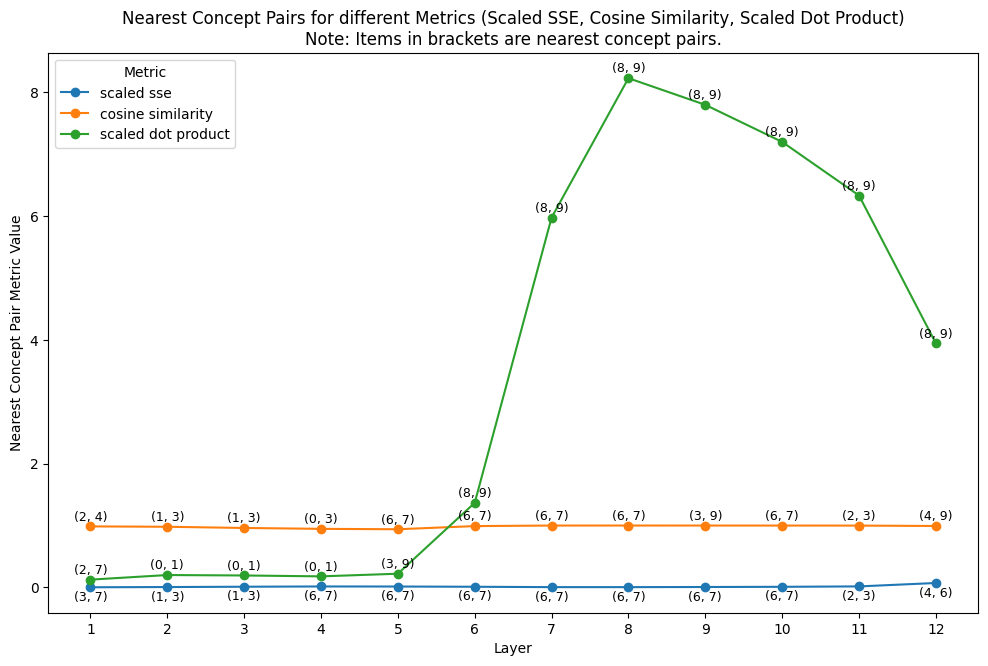

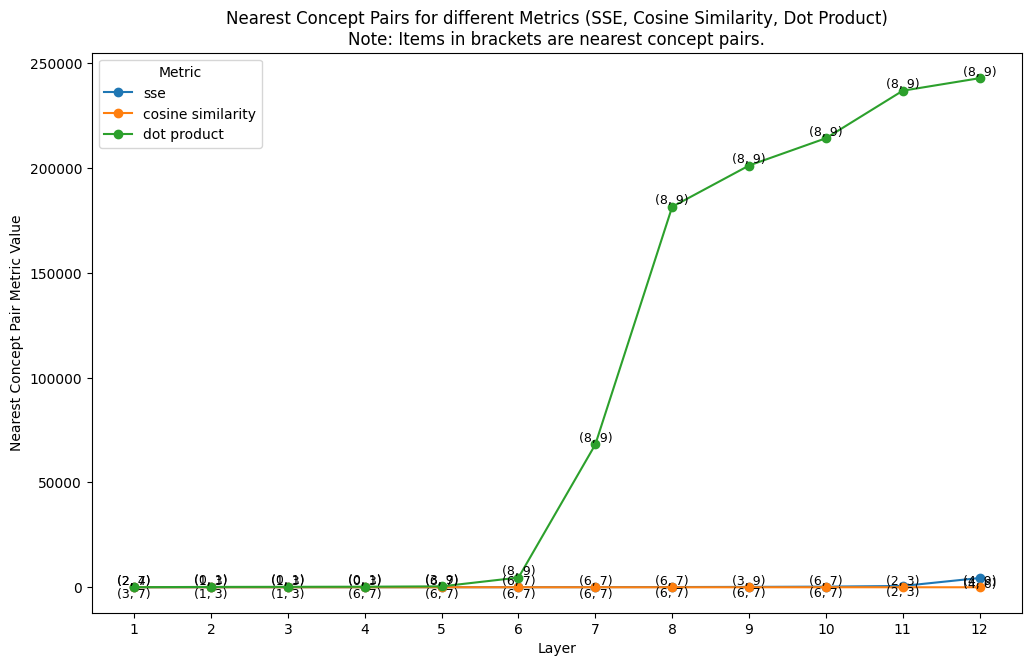

CSV file saved to images_nearest_concept_pipeline/K_value_50/nearest_concept_overview_viz/nearest_concept_overview.csv
Plots saved to images_nearest_concept_pipeline/K_value_50/nearest_concept_overview_viz


In [64]:
csv_path_nc = 'images_nearest_concept_pipeline/K_value_50/nearest_concepts_K_50.csv'
result_df = process_and_visualize_nearest_concepts(csv_path_nc)
# print(result_df)

In [332]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def process_and_visualize_nearest_concepts_without_basic(csv_path_nc):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path_nc)

    # Remove rows with relevance_type = 'basic'
    df = df[df['relevance_type'] != 'basic']

    # Initialize an empty list to store the selected rows
    selected_rows = []

    # Group by 'layer' and 'metric'
    grouped = df.groupby(['layer', 'metric'])

    # Iterate over each group
    for (layer, metric), group in grouped:
        if metric in ['sse', 'sse_scaled']:
            # Find the row with the lowest 'nearest_concept_pair_metric_value'
            selected_row = group.loc[group['nearest_concept_pair_metric_value'].idxmin()]
        else:
            # For all other metrics, find the row with the highest 'nearest_concept_pair_metric_value'
            selected_row = group.loc[group['nearest_concept_pair_metric_value'].idxmax()]
        
        # Append the selected row to the list
        selected_rows.append(selected_row)

    # Create a new DataFrame from the selected rows
    result_df = pd.DataFrame(selected_rows, columns=['layer', 'metric', 'nearest_concept_pair', 'nearest_concept_pair_metric_value'])

    # Reset the index
    result_df.reset_index(drop=True, inplace=True)

    # Save the result_df as a CSV file
    output_directory = 'images_nearest_concept_pipeline/K_value_50/nearest_concept_overview_viz'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    result_csv_path = os.path.join(output_directory, 'nearest_concept_overview_without_basic.csv')
    result_df.to_csv(result_csv_path, index=False)

    # Dictionary to map metric names for visualization
    metric_name_map = {
        'cosine': 'Cosine Similarity',
        'sse_scaled': 'SSE (Scaled)',
    }

    # Visualization: sse_scaled, cosine
    plt.figure(figsize=(10, 6), dpi=73)  # Use the same dimensions as the plot_norms function
    metrics_to_plot = ['sse_scaled', 'cosine']

    for metric in metrics_to_plot:
        subset = result_df[result_df['metric'] == metric]
        plt.plot(subset['layer'] - 1,  # Adjust layer numbers to start from 0
                 subset['nearest_concept_pair_metric_value'], label=metric_name_map[metric], marker='o')
        
        # Annotate points with nearest_concept_pair
        for i, row in subset.iterrows():
            if metric == 'cosine':
                plt.text(row['layer'] - 1, row['nearest_concept_pair_metric_value'] - 0.02,  # Adjusted for new x-axis
                         f"{row['nearest_concept_pair']}", fontsize=15, ha='center', va='top')
            elif metric == 'sse_scaled':
                plt.text(row['layer'] - 1, row['nearest_concept_pair_metric_value'] + 0.02,  # Adjusted for new x-axis
                         f"{row['nearest_concept_pair']}", fontsize=15, ha='center', va='bottom')

    plt.title('Between-Concept Overview', fontsize=15)  # Adjusted title font size
    plt.xlabel('Layer', fontsize=15)  # Adjusted x-axis label font size
    plt.ylabel('Metric', fontsize=15)  # Adjusted y-axis label font size
    plt.xticks(range(0, 12, 2), fontsize=15)  # Updated to show layers 0 to 11
    plt.yticks(fontsize=15)  # Adjusted y-ticks font size

    # Add custom legend entry for annotation explanation in bold and two lines
    custom_legend = plt.Line2D([0], [0], color='white', label=r'$\bf{Annotated\ Tuples\ are}$' + '\n' + r'$\bf{Most\ Similar\ Concept\ Pairs}$')
    
    # Add the legend with the custom entry
    plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [custom_legend], loc='center right', fontsize=12)

    # Adjust layout manually
#     plt.subplots_adjust(bottom=0.15, top=0.85, right=0.75)

    # Save the plot
    plot_path = os.path.join(output_directory, 'nearest_concept_overview_viz_without_basic_metrics.png')
    plt.savefig(plot_path, dpi=73)
    plt.show()

    print(f"CSV file saved to {result_csv_path}")
    print(f"Plot saved to {plot_path}")

    return result_df


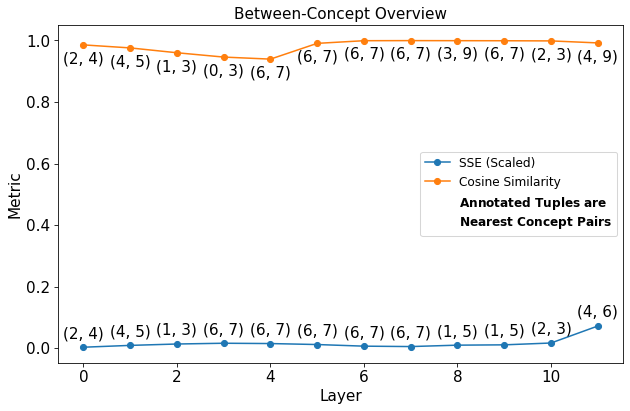

CSV file saved to images_nearest_concept_pipeline/K_value_50/nearest_concept_overview_viz/nearest_concept_overview_without_basic.csv
Plot saved to images_nearest_concept_pipeline/K_value_50/nearest_concept_overview_viz/nearest_concept_overview_viz_without_basic_metrics.png


In [333]:
csv_path_nc = 'images_nearest_concept_pipeline/K_value_50/nearest_concepts_K_50.csv'
result_df = process_and_visualize_nearest_concepts_without_basic(csv_path_nc)

In [55]:
# import csv

# # Define the file path for the CSV
# directory = 'images_nearest_concept_pipeline/K_value_50'
# file_path_cm = os.path.join(directory, 'concept_metrics_all_K_50.csv')

# # Create and write to the CSV file
# with open(file_path_cm, 'w', newline='') as csvfile:
#     # Define the fieldnames for the CSV
#     fieldnames = ['concept pair', 'metric', 'relevance type'] + [f'layer{i+1}' for i in range(12)]
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
#     # Write the header row
#     writer.writeheader()
    
#     # Iterate over each concept pair
#     for concept_pair, metrics_data in concept_metrics_all.items():
#         # Iterate over each metric
#         for metric, relevance_data in metrics_data.items():
#             # Iterate over each relevance type
#             for relevance, layer_values in relevance_data.items():
#                 # Write a row for each combination
#                 writer.writerow({
#                     'concept pair': concept_pair,
#                     'metric': metric,
#                     'relevance type': relevance,
#                     **{f'layer{i+1}': layer_values[i] for i in range(12)}
#                 })

# print(f"CSV file 'concept_metrics_all_K_50.csv' created successfully.")


CSV file 'concept_metrics_all_K_50.csv' created successfully.


### Creating Box plots

In [10]:
csv_path_cm = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'

In [16]:
def generate_box_plots(csv_path_cm):
    # Set the style to 'default' for a clean and simple plot appearance
    plt.style.use('default')
    
    # Step 1: Load the CSV file
    df = pd.read_csv(csv_path_cm)

    # Calculate the average metric over all layers
    layer_columns = [f'layer{layer_num}' for layer_num in range(1, 13)]
    df['avg_metric_over_layers'] = df[layer_columns].mean(axis=1)

    # Step 2: Define the list of metrics and their display names
    metrics = {
        'sse': 'SSE',
        'cosine': 'Cosine Similarity',
        'dot': 'Dot Product',
        'sse_scaled': 'Scaled SSE',
        'dot_scaled': 'Scaled Dot Product'
    }

    # Step 3: Loop through each metric and create box plots
    for metric, display_name in metrics.items():
        # Step 3a: Create a subset DataFrame for the current metric
        sub_df = df[df['metric'] == metric]

        # Step 3b: Determine the unique relevance types in a consistent order
        relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]

        # Step 3c: Collect the 'avg_metric_over_layers' values for each relevance type
        data_to_plot = [sub_df[sub_df['relevance type'] == relevance]['avg_metric_over_layers'].values for relevance in relevance_types]

        # Step 3d: Create the box plot
        plt.figure(figsize=(12, 8))
        box = plt.boxplot(data_to_plot, patch_artist=True, labels=relevance_types)

        # Optional: Customize box colors
        colors = ['skyblue', 'lightgreen', 'lightcoral', 'lavender', 'lightyellow', 'lightgray']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels without transparency issues
        plt.title(f'Box Plot of {display_name} for Different Relevance Types', fontsize=14)
        plt.xlabel('Relevance Type', fontsize=12)
        plt.ylabel(f'Average {display_name} Over Layers', fontsize=12)

        # Rotate x-axis labels for better visibility
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjust layout to ensure everything fits without overlap
        plt.tight_layout()

        # Step 3e: Save and display the plot
        plt.savefig(f'images_nearest_concept_pipeline/K_value_50/boxplot_{metric}.png')  # Update the path if needed
        plt.show()

        print(f'Box plot for {display_name} saved as boxplot_{metric}.png')


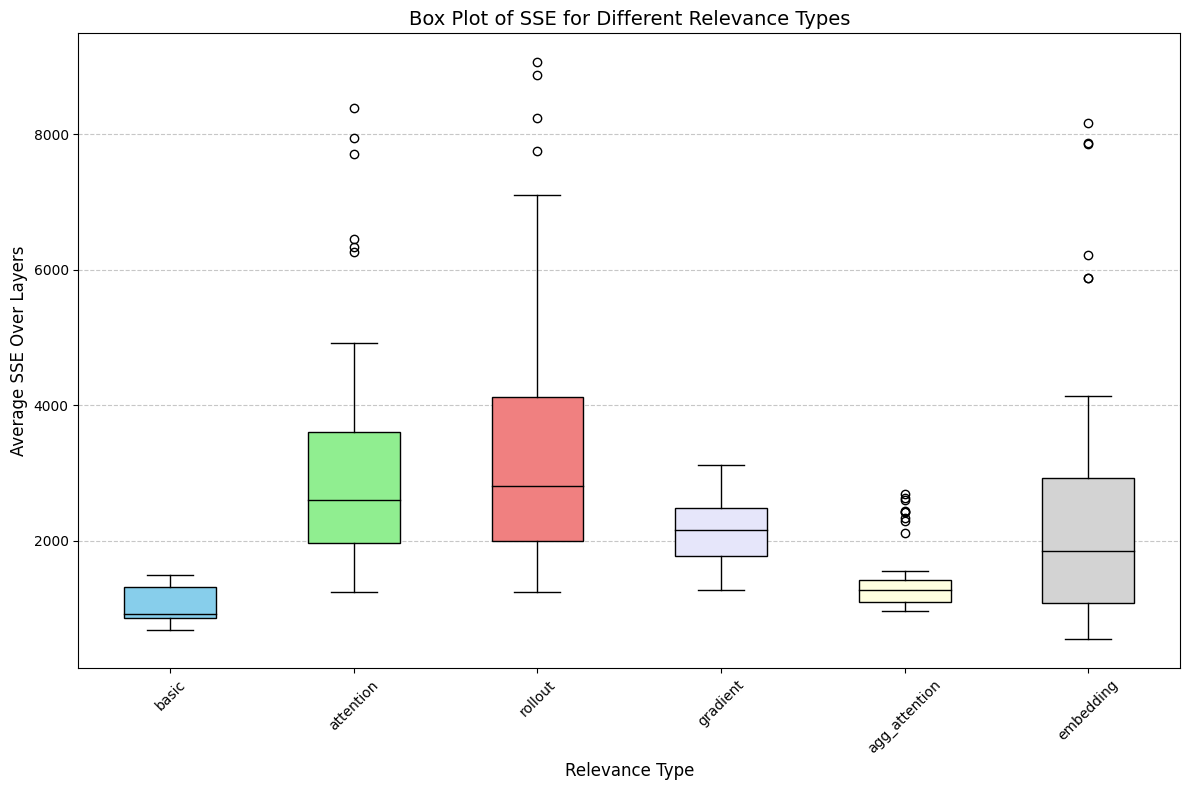

Box plot for SSE saved as boxplot_sse.png


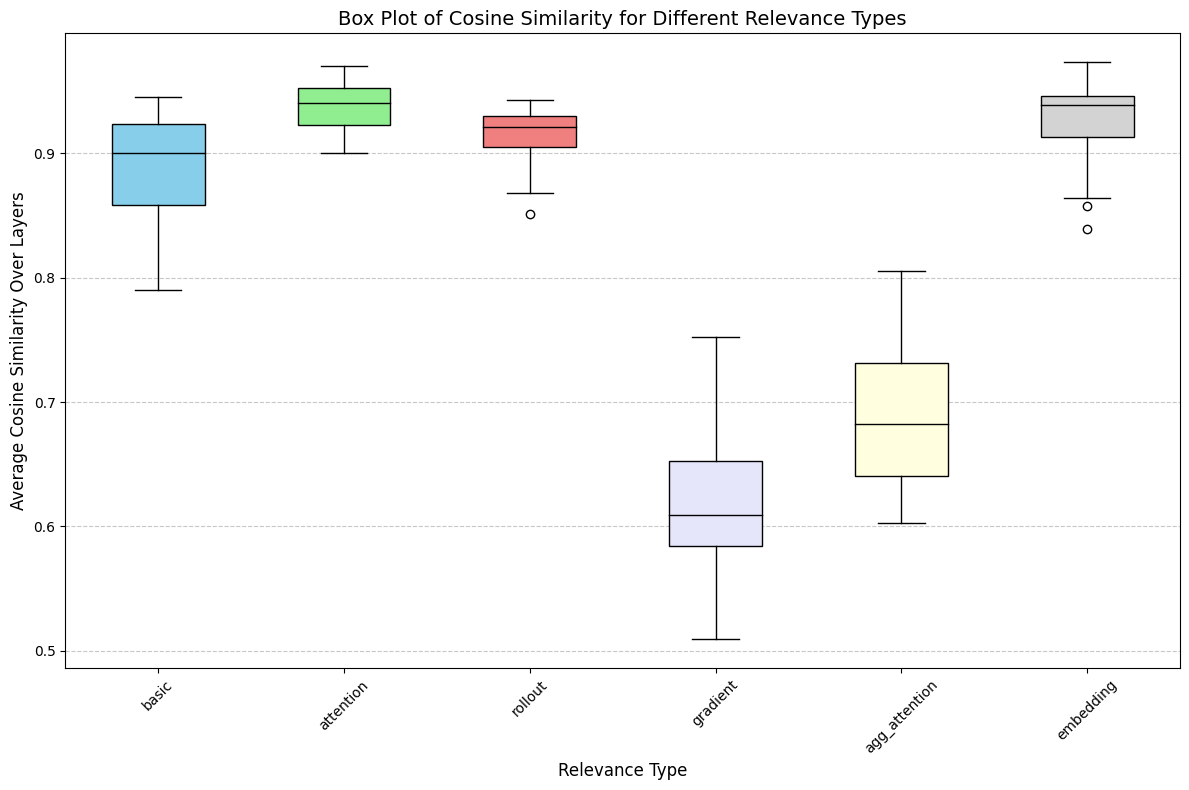

Box plot for Cosine Similarity saved as boxplot_cosine.png


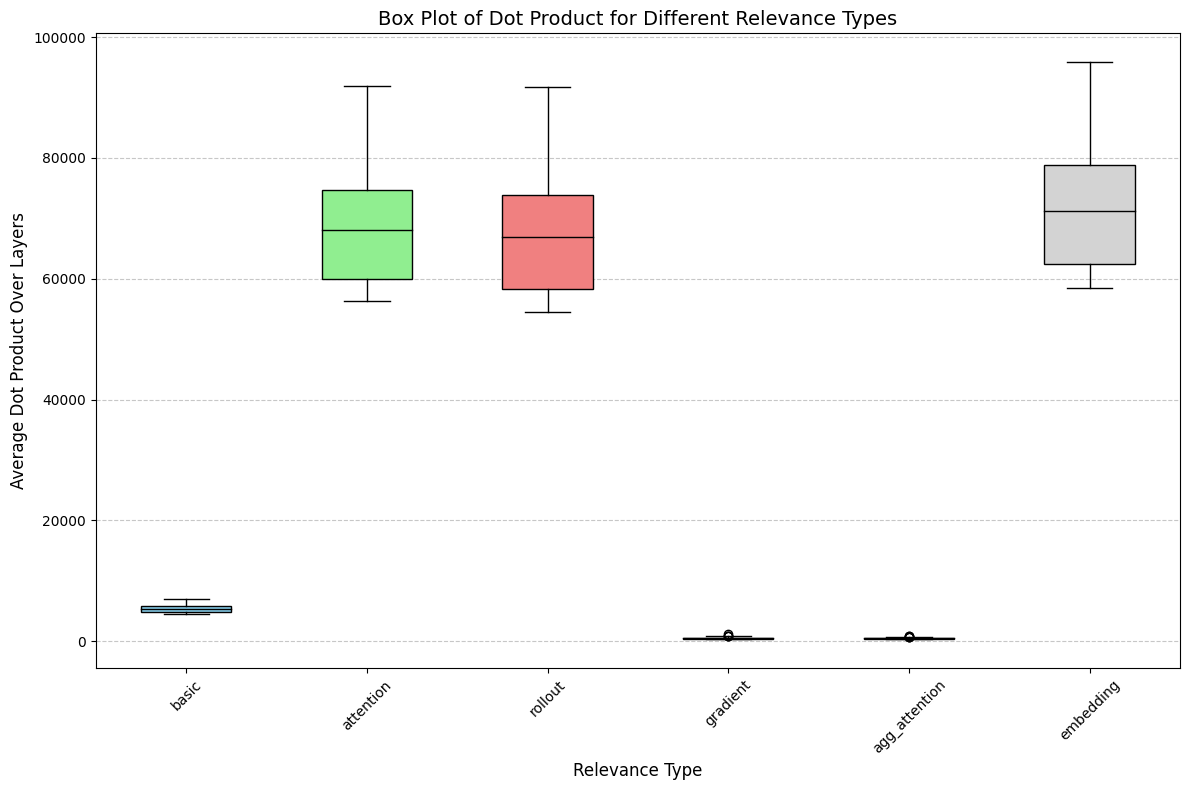

Box plot for Dot Product saved as boxplot_dot.png


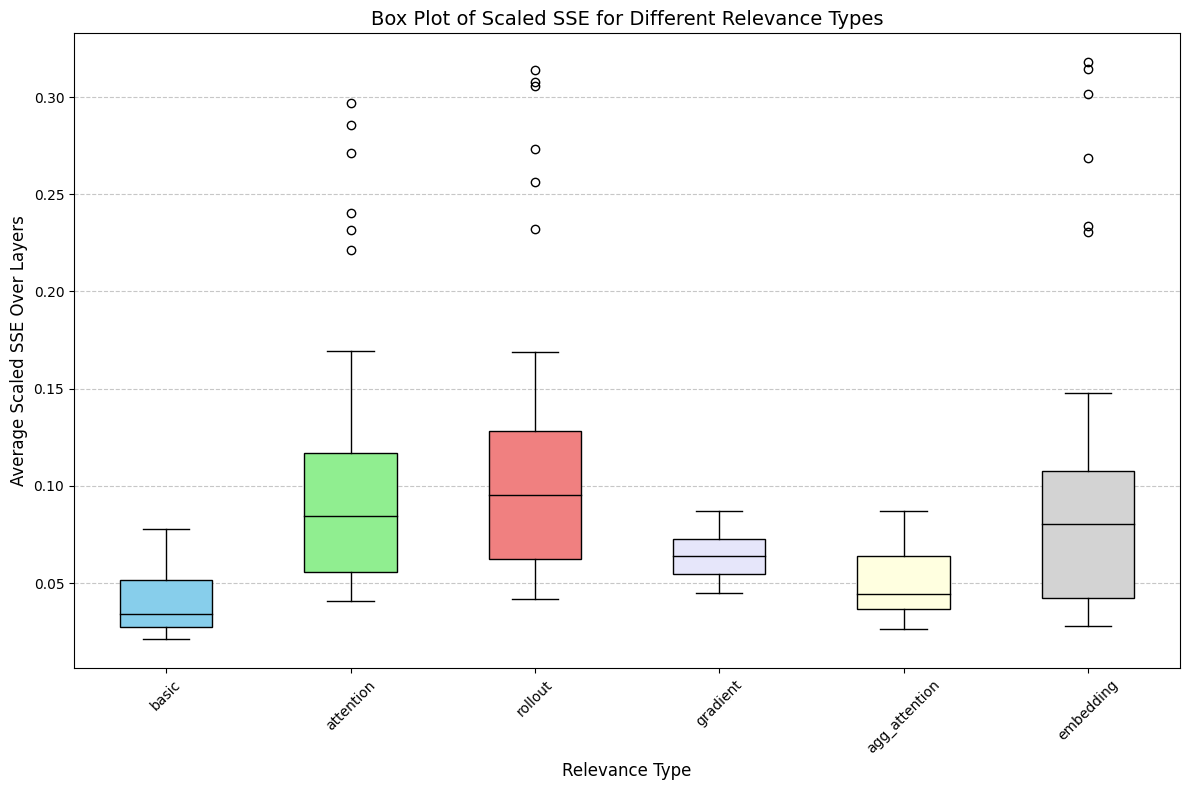

Box plot for Scaled SSE saved as boxplot_sse_scaled.png


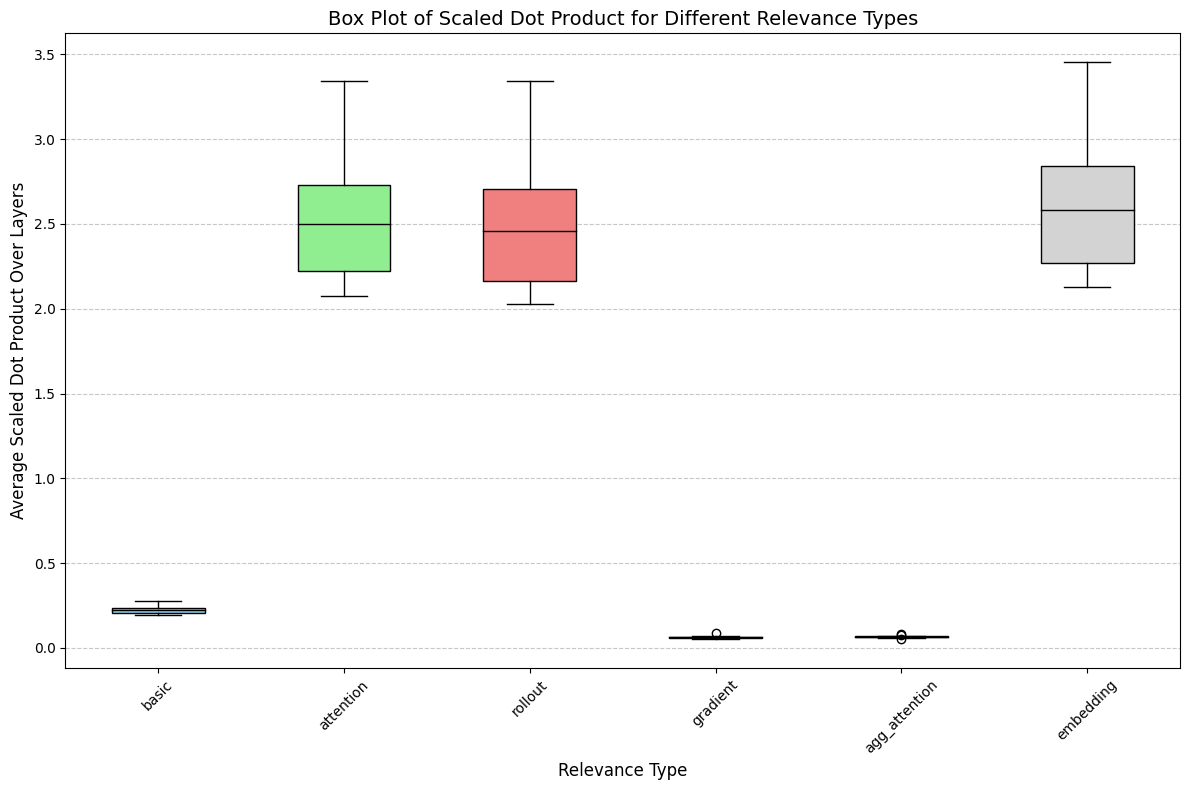

Box plot for Scaled Dot Product saved as boxplot_dot_scaled.png


In [17]:
generate_box_plots(csv_path_cm)

In [18]:
def generate_box_plots_no_outliers(csv_path_cm):
    # Set the style to 'default' for a clean and simple plot appearance
    plt.style.use('default')
    
    # Step 1: Load the CSV file
    df = pd.read_csv(csv_path_cm)

    # Calculate the average metric over all layers
    layer_columns = [f'layer{layer_num}' for layer_num in range(1, 13)]
    df['avg_metric_over_layers'] = df[layer_columns].mean(axis=1)

    # Step 2: Define the list of metrics and their display names
    metrics = {
        'sse': 'SSE',
        'cosine': 'Cosine Similarity',
        'dot': 'Dot Product',
        'sse_scaled': 'Scaled SSE',
        'dot_scaled': 'Scaled Dot Product'
    }

    # Step 3: Loop through each metric and create box plots
    for metric, display_name in metrics.items():
        # Step 3a: Create a subset DataFrame for the current metric
        sub_df = df[df['metric'] == metric]

        # Step 3b: Determine the unique relevance types in a consistent order
        relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]

        # Step 3c: Collect the 'avg_metric_over_layers' values for each relevance type
        data_to_plot = [sub_df[sub_df['relevance type'] == relevance]['avg_metric_over_layers'].values for relevance in relevance_types]

        # Step 3d: Create the box plot without outliers
        plt.figure(figsize=(12, 8))
        box = plt.boxplot(data_to_plot, patch_artist=True, labels=relevance_types, showfliers=False)

        # Optional: Customize box colors
        colors = ['skyblue', 'lightgreen', 'lightcoral', 'lavender', 'lightyellow', 'lightgray']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels without transparency issues
        plt.title(f'Box Plot of {display_name} for Different Relevance Types', fontsize=14)
        plt.xlabel('Relevance Type', fontsize=12)
        plt.ylabel(f'Average {display_name} Over Layers', fontsize=12)

        # Rotate x-axis labels for better visibility
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjust layout to ensure everything fits without overlap
        plt.tight_layout()

        # Step 3e: Save and display the plot
        plt.savefig(f'images_nearest_concept_pipeline/K_value_50/boxplot_{metric}_no_outliers.png')  # Update the path if needed
        plt.show()

        print(f'Box plot for {display_name} (No Outliers) saved as boxplot_{metric}_no_outliers.png')

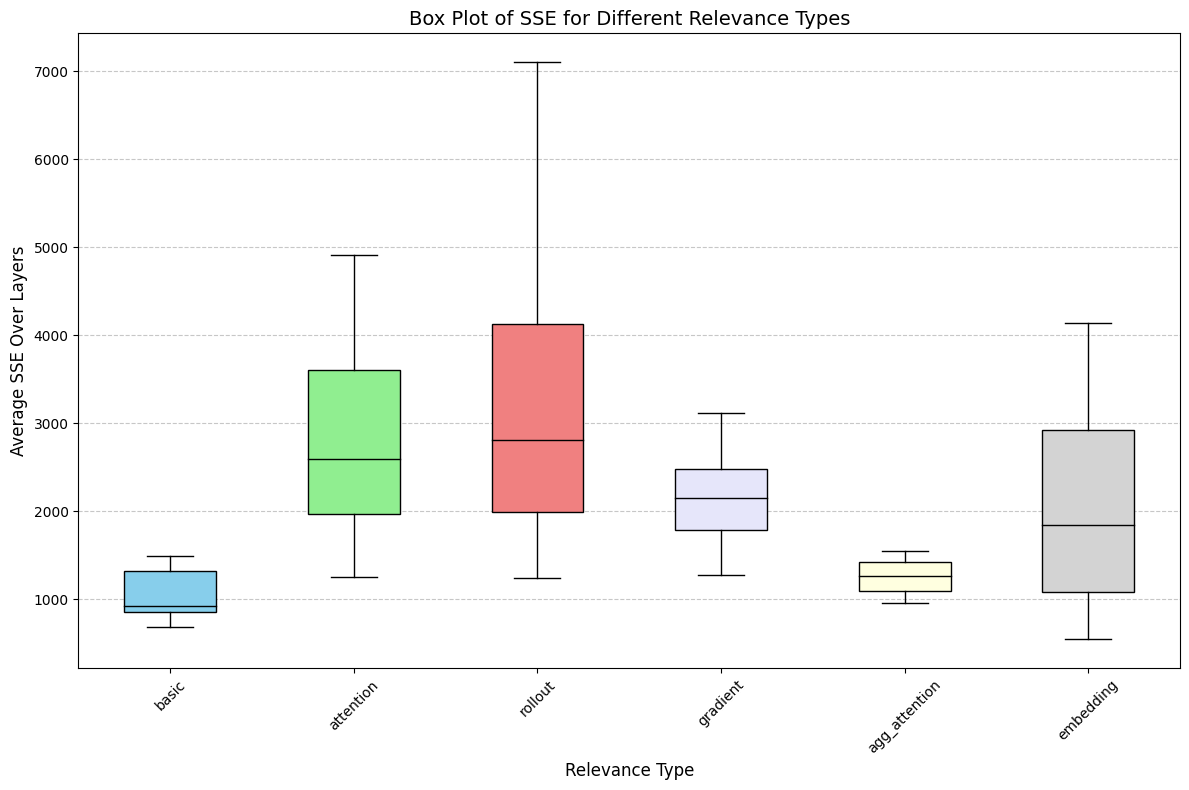

Box plot for SSE (No Outliers) saved as boxplot_sse_no_outliers.png


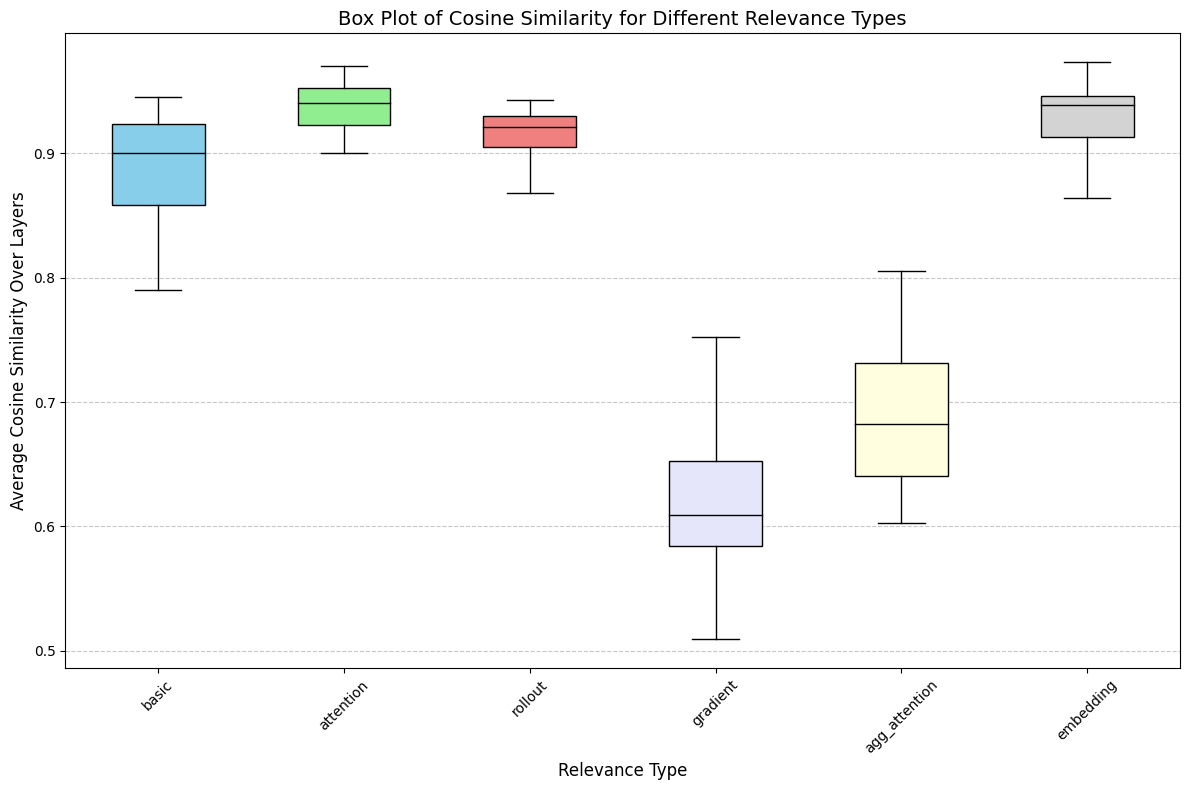

Box plot for Cosine Similarity (No Outliers) saved as boxplot_cosine_no_outliers.png


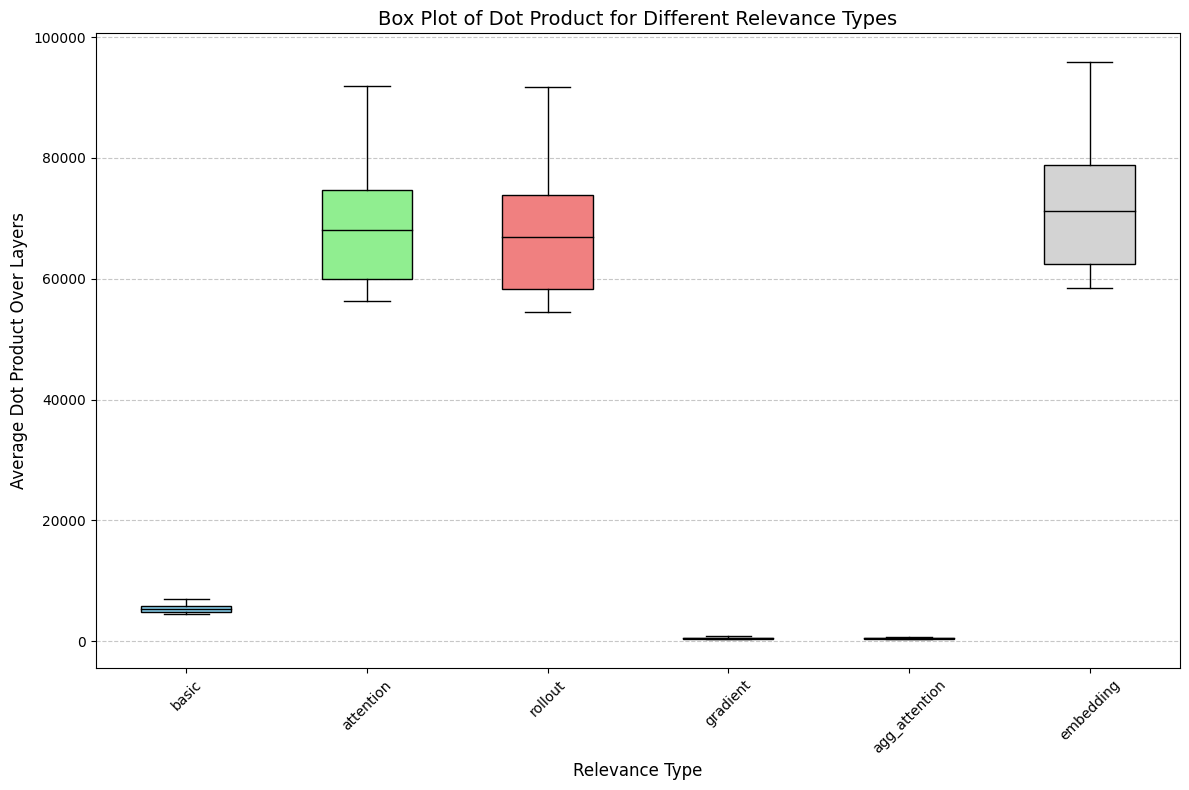

Box plot for Dot Product (No Outliers) saved as boxplot_dot_no_outliers.png


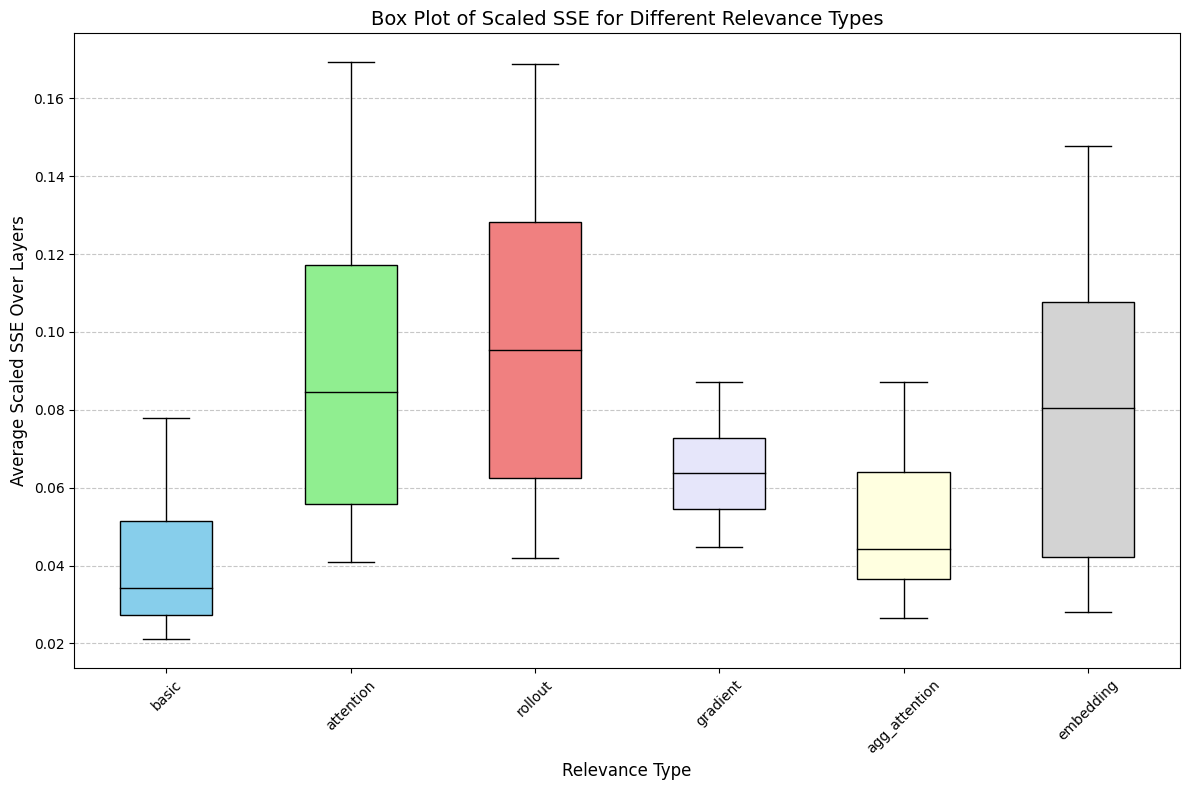

Box plot for Scaled SSE (No Outliers) saved as boxplot_sse_scaled_no_outliers.png


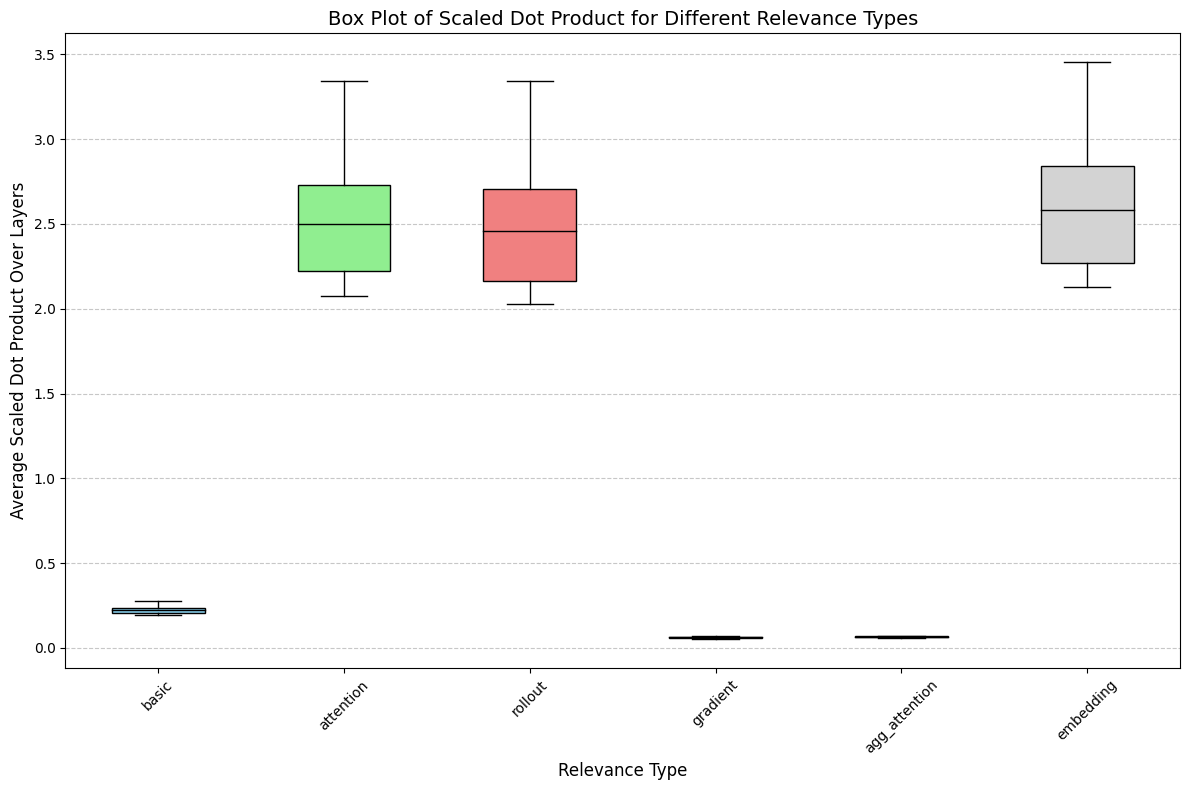

Box plot for Scaled Dot Product (No Outliers) saved as boxplot_dot_scaled_no_outliers.png


In [19]:
generate_box_plots_no_outliers(csv_path_cm)

### Dog, Fish, Truck plots

In [133]:
# Specify the CSV path
csv_path_cm = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'

In [134]:
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path_cm)
# print(df['concept pair'].values)

# Filter for specific concept pairs
filtered_df = df[df['concept pair'].isin(['(0, 1)', '(1, 6)'])]
# print(filtered_df)

# Further filter for rows where sse_scaled and gradient are together
sse_rollout_df = filtered_df[
    (filtered_df['metric'] == 'sse_scaled') &
    (filtered_df['relevance type'] == 'rollout')
]

# Further filter for rows where cosine and rollout are together
cosine_gradient_df = filtered_df[
    (filtered_df['metric'] == 'cosine') &
    (filtered_df['relevance type'] == 'gradient')
]

# Combine the two DataFrames
result_df = pd.concat([sse_rollout_df, cosine_gradient_df], ignore_index=True)

# Display the final filtered DataFrame
print(result_df)

  concept pair      metric relevance type    layer1    layer2    layer3  \
0       (0, 1)  sse_scaled        rollout  0.015674  0.035234  0.040248   
1       (1, 6)  sse_scaled        rollout  0.023169  0.034999  0.047834   
2       (0, 1)      cosine       gradient  0.969900  0.934273  0.914004   
3       (1, 6)      cosine       gradient  0.908564  0.915852  0.862949   

     layer4    layer5    layer6    layer7    layer8    layer9   layer10  \
0  0.046944  0.046580  0.037006  0.017908  0.019269  0.021428  0.032669   
1  0.063805  0.065543  0.051899  0.026527  0.017747  0.021220  0.029298   
2  0.889183  0.873580  0.827687  0.736701  0.596146  0.507420  0.365592   
3  0.810633  0.761851  0.701333  0.624977  0.536829  0.465812  0.358381   

    layer11   layer12  
0  0.089481  0.324786  
1  0.069411  0.303239  
2  0.237529  0.574364  
3  0.204775  0.201010  


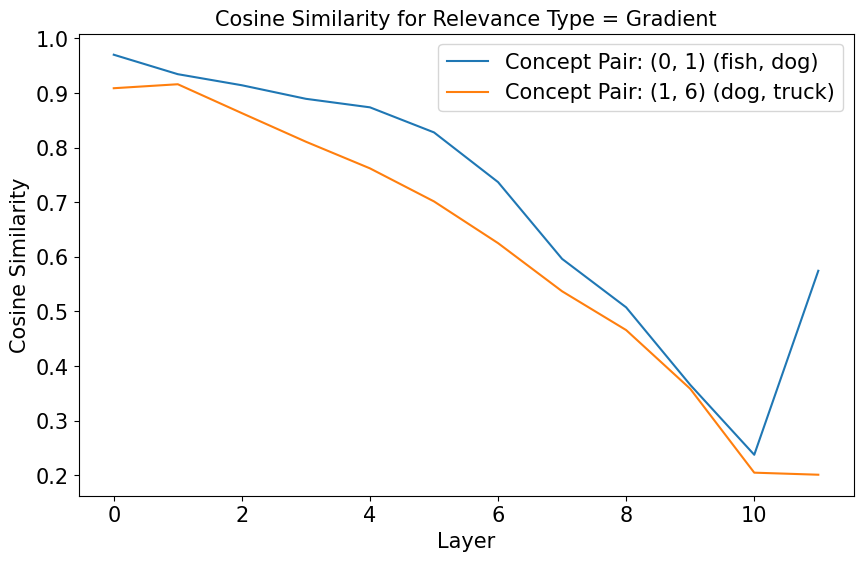

Plot saved to images_nearest_concept_pipeline/K_value_50/dog_fish_truck/Cosine_Similarity_Gradient.png


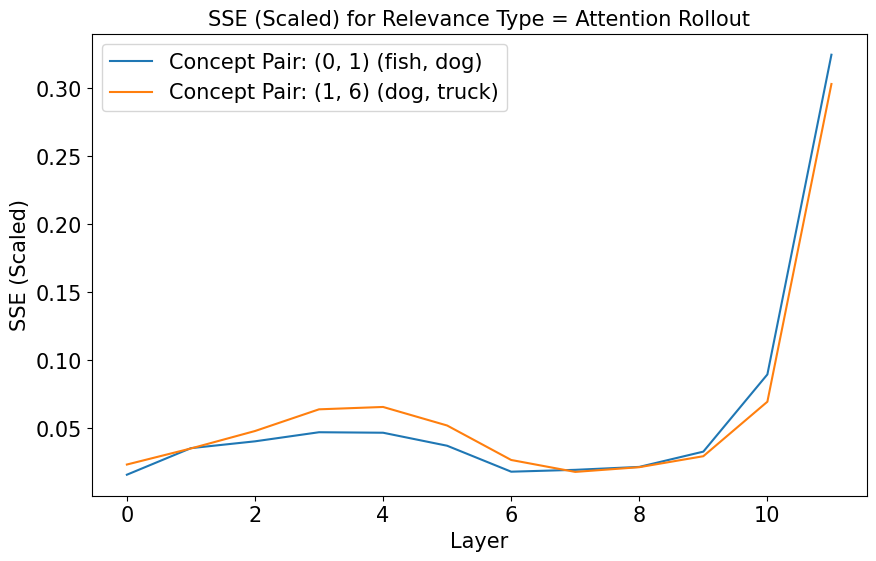

Plot saved to images_nearest_concept_pipeline/K_value_50/dog_fish_truck/Scaled_SSE_Rollout.png


In [135]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metric_by_layers_DFT(result_df, metric, relevance_type, output_path, file_name, y_label, title):
    # Filter the DataFrame for the specified metric and relevance type
    filtered_df = result_df[(result_df['metric'] == metric) & (result_df['relevance type'] == relevance_type)]

    # Extract the layers' data
    layers = [f'layer{i}' for i in range(1, 13)]
    concept_pairs = filtered_df['concept pair'].tolist()

    # Plot the data for each concept pair
    plt.figure(figsize=(10, 6))
    for i, concept_pair in enumerate(concept_pairs):
        layer_values = filtered_df[filtered_df['concept pair'] == concept_pair][layers].values.flatten()
        label = f'Concept Pair: {concept_pair} '
        if concept_pair == '(0, 1)':
            label += '(fish, dog)'
        elif concept_pair == '(1, 6)':
            label += '(dog, truck)'
        plt.plot(range(1, 13), layer_values, label=label)

    # Update the labels, title, and legend
    plt.xlabel('Layer', fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.title(title, fontsize=15)
    plt.xticks([1, 3, 5, 7, 9, 11], labels=[0, 2, 4, 6, 8, 10], fontsize=15)  # Adjust x-axis to start from 0 and show only even layers
    plt.yticks(fontsize=15)  # Set y-tick font size
    plt.legend(fontsize=15)  # Set legend font size

    # Save the plot
    output_file = f"{output_path}/{file_name}.png"
    plt.savefig(output_file)
    plt.show()
    print(f"Plot saved to {output_file}")

# Define the output path for the images
output_path = 'images_nearest_concept_pipeline/K_value_50/dog_fish_truck'

# Plot for Cosine Similarity with Gradient
plot_metric_by_layers_DFT(result_df, 'cosine', 'gradient', output_path, 
                      'Cosine_Similarity_Gradient', 'Cosine Similarity', 
                      'Cosine Similarity for Relevance Type = Gradient')

# Plot for Scaled SSE with Rollout
plot_metric_by_layers_DFT(result_df, 'sse_scaled', 'rollout', output_path, 
                      'Scaled_SSE_Rollout', 'SSE (Scaled)', 
                      'SSE (Scaled) for Relevance Type = Attention Rollout')


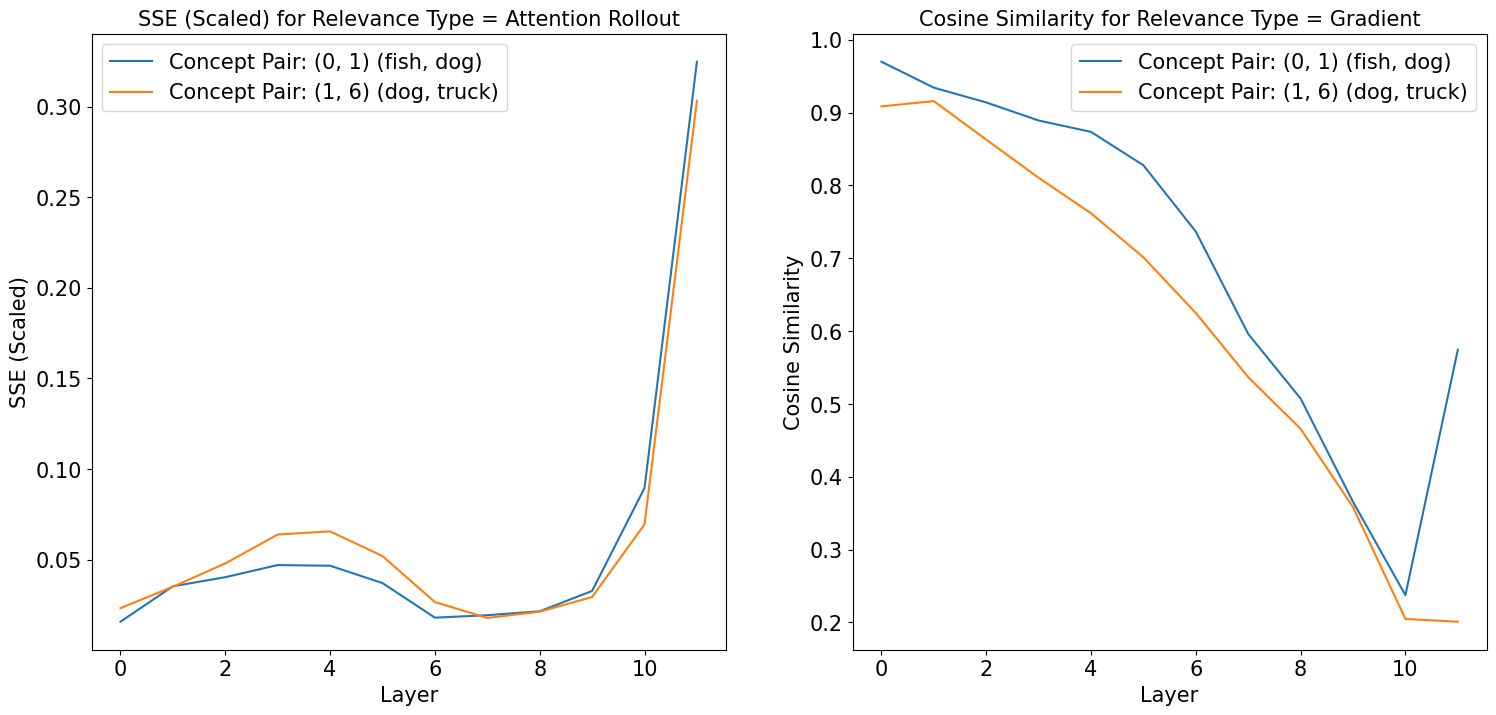

Plot saved to images_nearest_concept_pipeline/K_value_50/dog_fish_truck/SSE_Rollout_and_Cosine_Gradient_side_by_side.png


In [140]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metric_by_layers_DFT_side_by_side(result_df, metric1, relevance_type1, metric2, relevance_type2, output_path, file_name, y_label1, y_label2, title1, title2):
    # Filter the DataFrame for the specified metric and relevance type
    filtered_df1 = result_df[(result_df['metric'] == metric1) & (result_df['relevance type'] == relevance_type1)]
    filtered_df2 = result_df[(result_df['metric'] == metric2) & (result_df['relevance type'] == relevance_type2)]

    # Extract the layers' data
    layers = [f'layer{i}' for i in range(1, 13)]
    concept_pairs1 = filtered_df1['concept pair'].tolist()
    concept_pairs2 = filtered_df2['concept pair'].tolist()

    # Create subplots for side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # Set figure size to 18x8

    # Plot the data for each concept pair in the first plot
    for i, concept_pair in enumerate(concept_pairs1):
        layer_values1 = filtered_df1[filtered_df1['concept pair'] == concept_pair][layers].values.flatten()
        label = f'Concept Pair: {concept_pair} '
        if concept_pair == '(0, 1)':
            label += '(fish, dog)'
        elif concept_pair == '(1, 6)':
            label += '(dog, truck)'
        axes[0].plot(range(1, 13), layer_values1, label=label)

    axes[0].set_xlabel('Layer', fontsize=15)
    axes[0].set_ylabel(y_label1, fontsize=15)
    axes[0].set_title(title1, fontsize=15)
    axes[0].set_xticks([1, 3, 5, 7, 9, 11])
    axes[0].set_xticklabels([0, 2, 4, 6, 8, 10], fontsize=15)  # Adjust the labels to start from 0
    axes[0].tick_params(axis='y', labelsize=15)  # Set y-tick font size
    axes[0].legend(fontsize=15)  # Set legend font size

    # Plot the data for each concept pair in the second plot
    for i, concept_pair in enumerate(concept_pairs2):
        layer_values2 = filtered_df2[filtered_df2['concept pair'] == concept_pair][layers].values.flatten()
        label = f'Concept Pair: {concept_pair} '
        if concept_pair == '(0, 1)':
            label += '(fish, dog)'
        elif concept_pair == '(1, 6)':
            label += '(dog, truck)'
        axes[1].plot(range(1, 13), layer_values2, label=label)

    axes[1].set_xlabel('Layer', fontsize=15)
    axes[1].set_ylabel(y_label2, fontsize=15)
    axes[1].set_title(title2, fontsize=15)
    axes[1].set_xticks([1, 3, 5, 7, 9, 11])
    axes[1].set_xticklabels([0, 2, 4, 6, 8, 10], fontsize=15)  # Adjust the labels to start from 0
    axes[1].tick_params(axis='y', labelsize=15)  # Set y-tick font size
    axes[1].legend(fontsize=15)  # Set legend font size

    # Adjust layout to ensure no overlap and add more space between the plots
    plt.subplots_adjust(wspace=0.2)  # Increase the space between the plots

    # Save the plot
    output_file = f"{output_path}/{file_name}.png"
    plt.savefig(output_file)
    plt.show()
    print(f"Plot saved to {output_file}")

# Define the output path for the images
output_path = 'images_nearest_concept_pipeline/K_value_50/dog_fish_truck'

# Plot for Scaled SSE with Rollout and Cosine Similarity with Gradient
plot_metric_by_layers_DFT_side_by_side(result_df, 'sse_scaled', 'rollout', 'cosine', 'gradient', 
                                       output_path, 'SSE_Rollout_and_Cosine_Gradient_side_by_side', 
                                       'SSE (Scaled)', 'Cosine Similarity', 
                                       'SSE (Scaled) for Relevance Type = Attention Rollout', 
                                       'Cosine Similarity for Relevance Type = Gradient')


# COMBINED NEAREST CONCEPT AND WITHIN CONCEPT BOXPLOTS

In [143]:
import pandas as pd

def process_nearest_concept_csv(csv_path):
    # Step 1: Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Step 2: Rename columns
    df.rename(columns={'concept pair': 'concept_pair', 'relevance type': 'relevance_type'}, inplace=True)
    
    # Step 3: Calculate the average metric over all layers
    layer_columns = [f'layer{layer_num}' for layer_num in range(1, 13)]
    df['avg_metric_over_layers'] = df[layer_columns].mean(axis=1)
    
    # Step 4: Write the updated DataFrame back to the original CSV file
    df.to_csv(csv_path, index=False)
    print(f'Updated DataFrame has been saved back to {csv_path}')

# Example usage:
nearest_csv_path = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'
process_nearest_concept_csv(nearest_csv_path)


Updated DataFrame has been saved back to images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv


### Separate plot for each metric with outliers

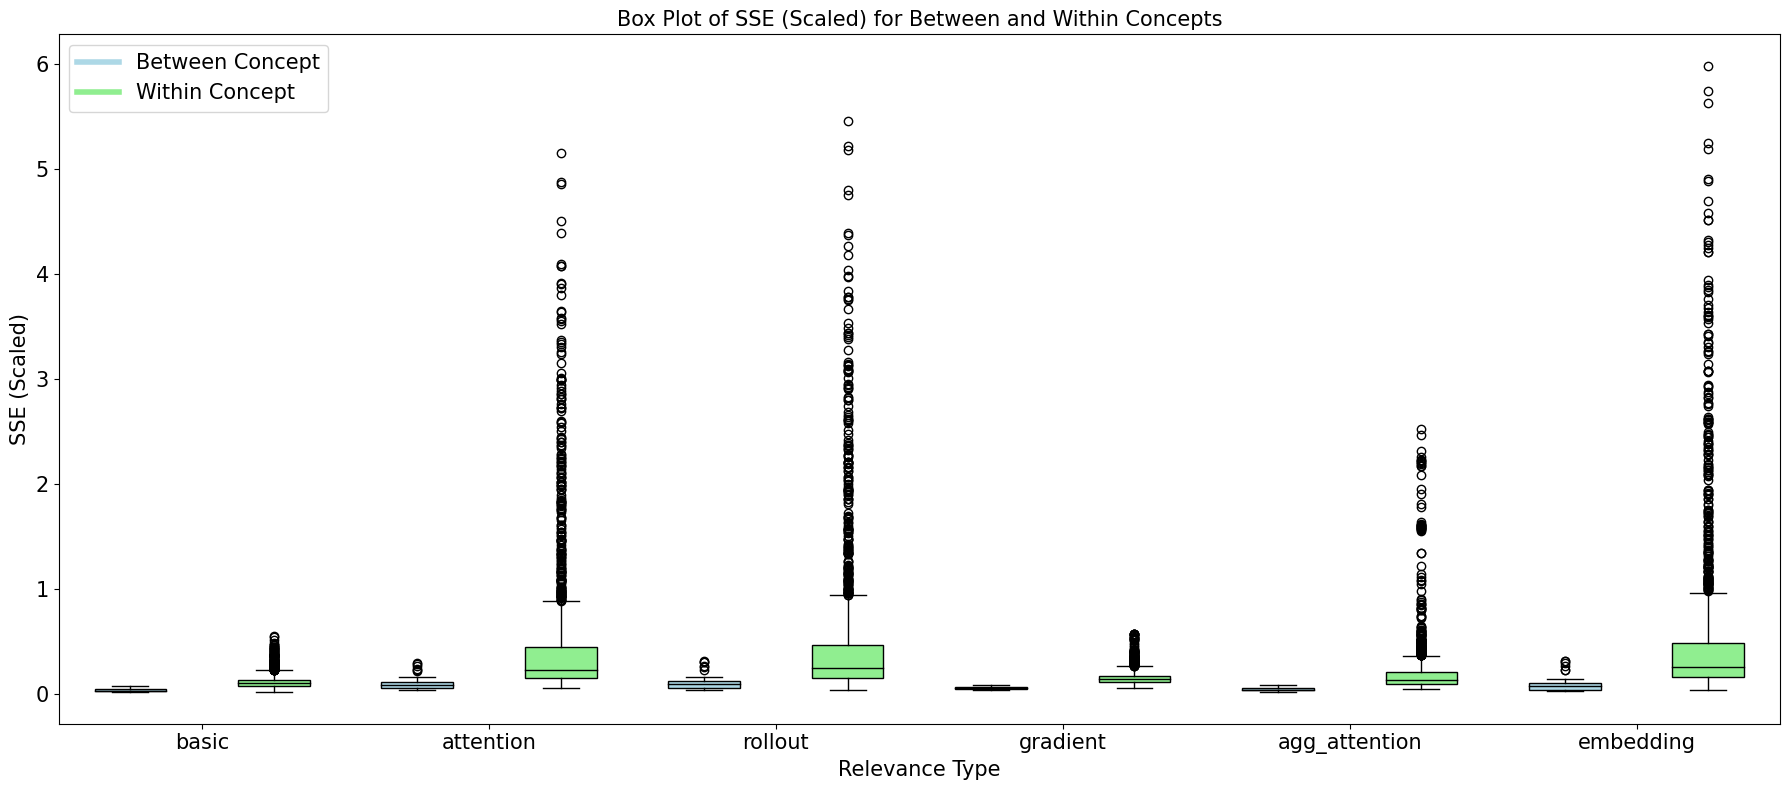

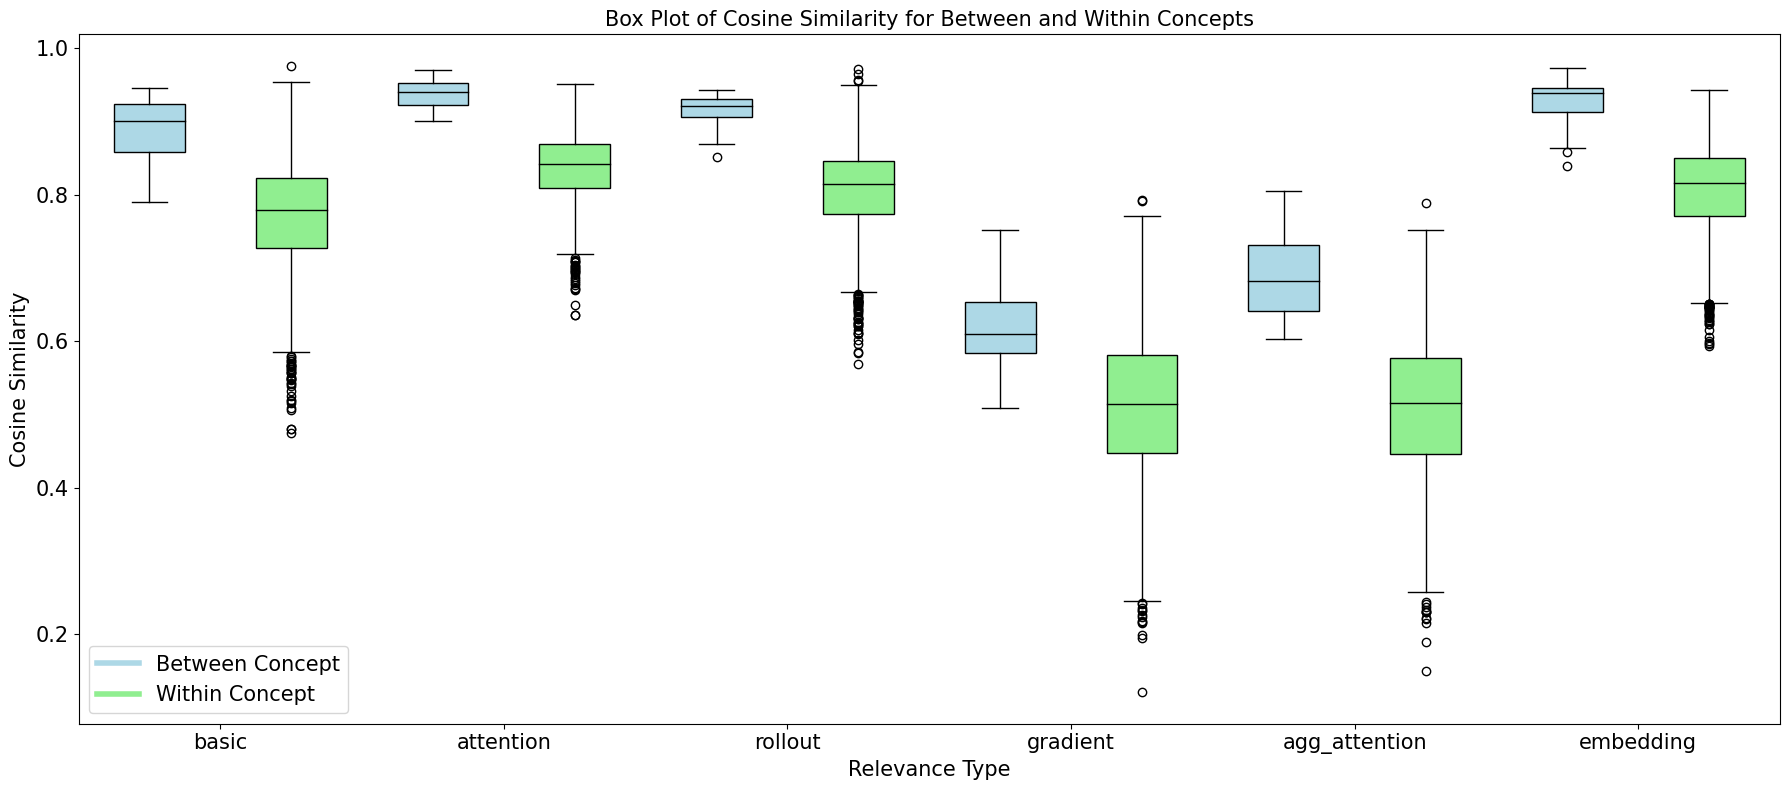

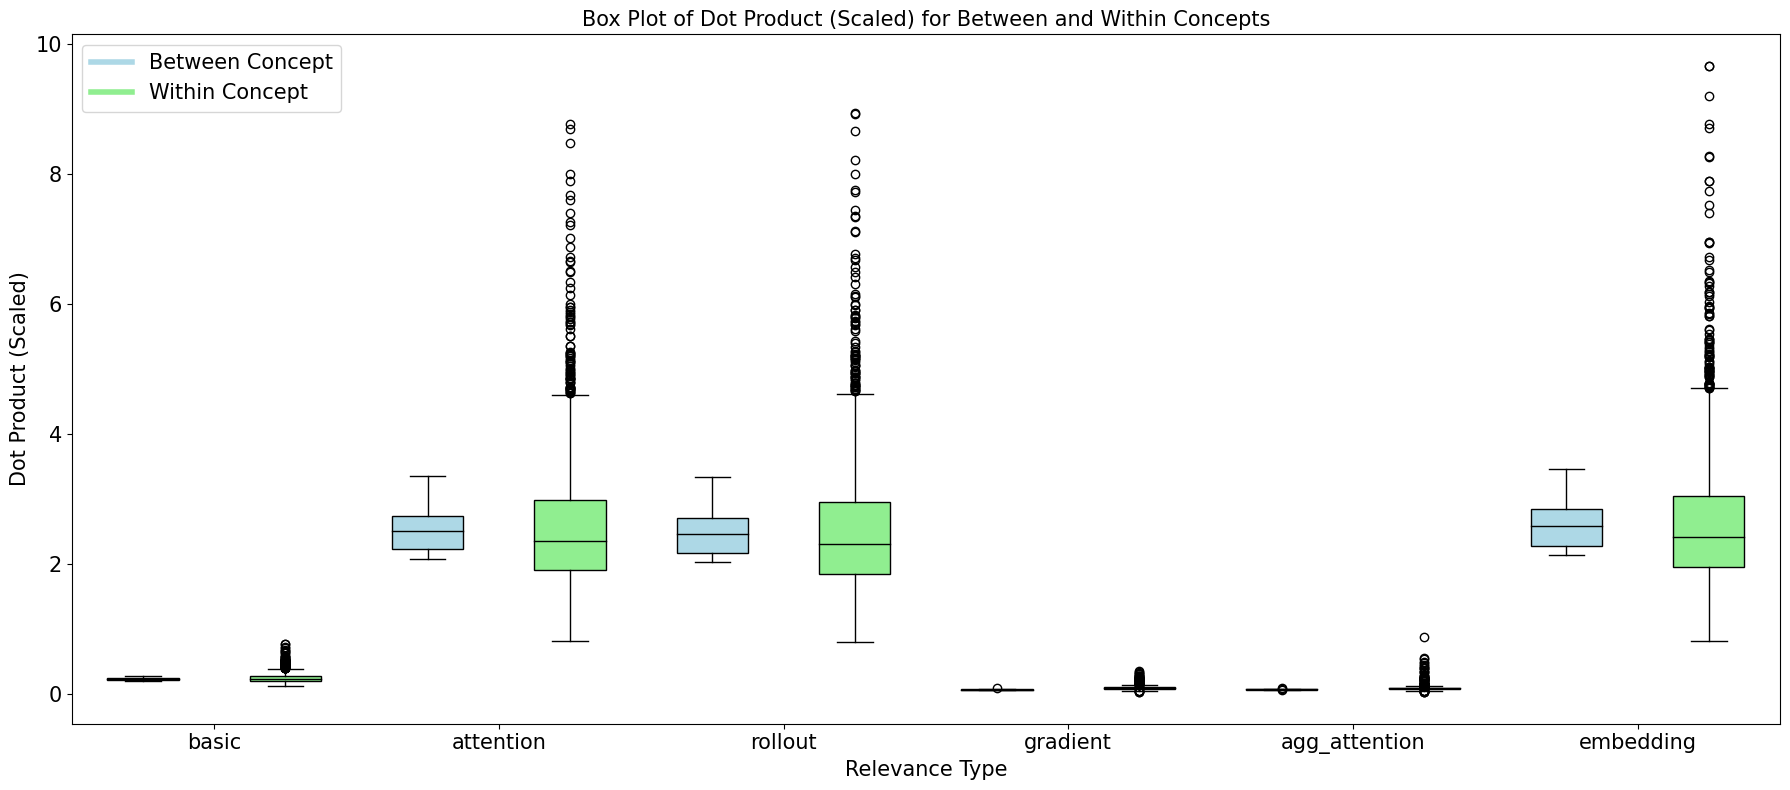

In [200]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def create_combined_box_plots(nearest_df, within_df, output_path):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Define the list of metrics and their display names
    metrics = {
        'sse_scaled': 'SSE (Scaled)',
        'cosine': 'Cosine Similarity',
        'dot_scaled': 'Dot Product (Scaled)'
    }
    
    # Define the relevance types in a consistent order
    relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]
    
    # Define the colors
    nearest_color = 'lightblue'
    within_color = 'lightgreen'

    # Loop through each metric and create combined box plots
    for metric, display_name in metrics.items():
        # Filter the DataFrames for the current metric
        nearest_metric_df = nearest_df[nearest_df['metric'] == metric]
        within_metric_df = within_df[within_df['metric'] == metric]
        
        # Prepare the data for plotting
        data_to_plot = []
        box_colors = []
        
        for relevance in relevance_types:
            # Collect data for nearest and within concept
            nearest_data = nearest_metric_df[nearest_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            within_data = within_metric_df[within_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            
            # Append data and colors
            data_to_plot.append(nearest_data)
            box_colors.append(nearest_color)

            data_to_plot.append(within_data)
            box_colors.append(within_color)
        
        # Create the box plot
        plt.figure(figsize=(18, 8))
        box = plt.boxplot(data_to_plot, patch_artist=True)
        
        # Customize box colors
        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels
        plt.title(f'Box Plot of {display_name} for Between and Within Concepts', fontsize=15)
        plt.xlabel('Relevance Type', fontsize=15)
        plt.ylabel(f'{display_name}', fontsize=15)
        plt.yticks(fontsize=15)

        # Customize the x-ticks to place relevance type labels between the two box plots
        num_boxes = len(data_to_plot)
        positions = list(range(1, num_boxes + 1))
        midpoint_positions = [(positions[i] + positions[i + 1]) / 2 for i in range(0, len(positions), 2)]

        plt.xticks(ticks=midpoint_positions, labels=relevance_types, fontsize=15)

        # Add legend for the colors
        handles = [
            plt.Line2D([0], [0], color=nearest_color, lw=4, label='Between Concept'),
            plt.Line2D([0], [0], color=within_color, lw=4, label='Within Concept')
        ]
        plt.legend(handles=handles, fontsize=15)

        plt.tight_layout()
        
        # Save and display the plot
        plt.savefig(f'{output_path}/combined_boxplot_{metric}.png')
        plt.show()

# Load the CSV files
nearest_csv_path = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'
within_csv_path = 'images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/All_Concepts_Boxplot_data.csv'

nearest_df = pd.read_csv(nearest_csv_path)
within_df = pd.read_csv(within_csv_path)

# Define the output path for the images
output_path = 'images_combined_box_plots'

# Generate the combined box plots
create_combined_box_plots(nearest_df, within_df, output_path)


### Separate plot for each metric without outliers

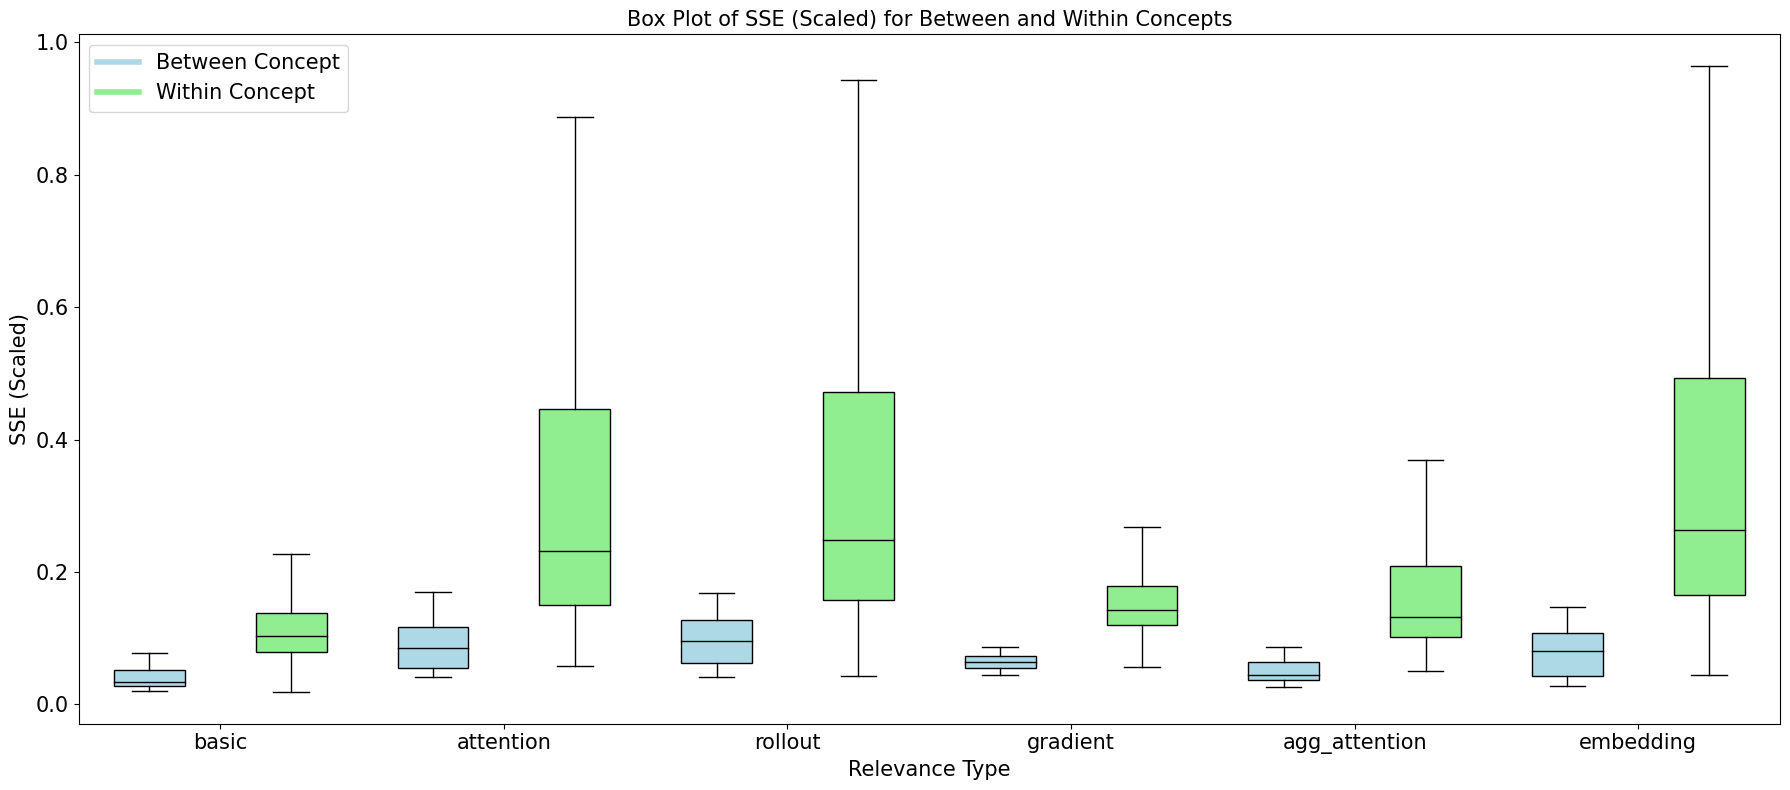

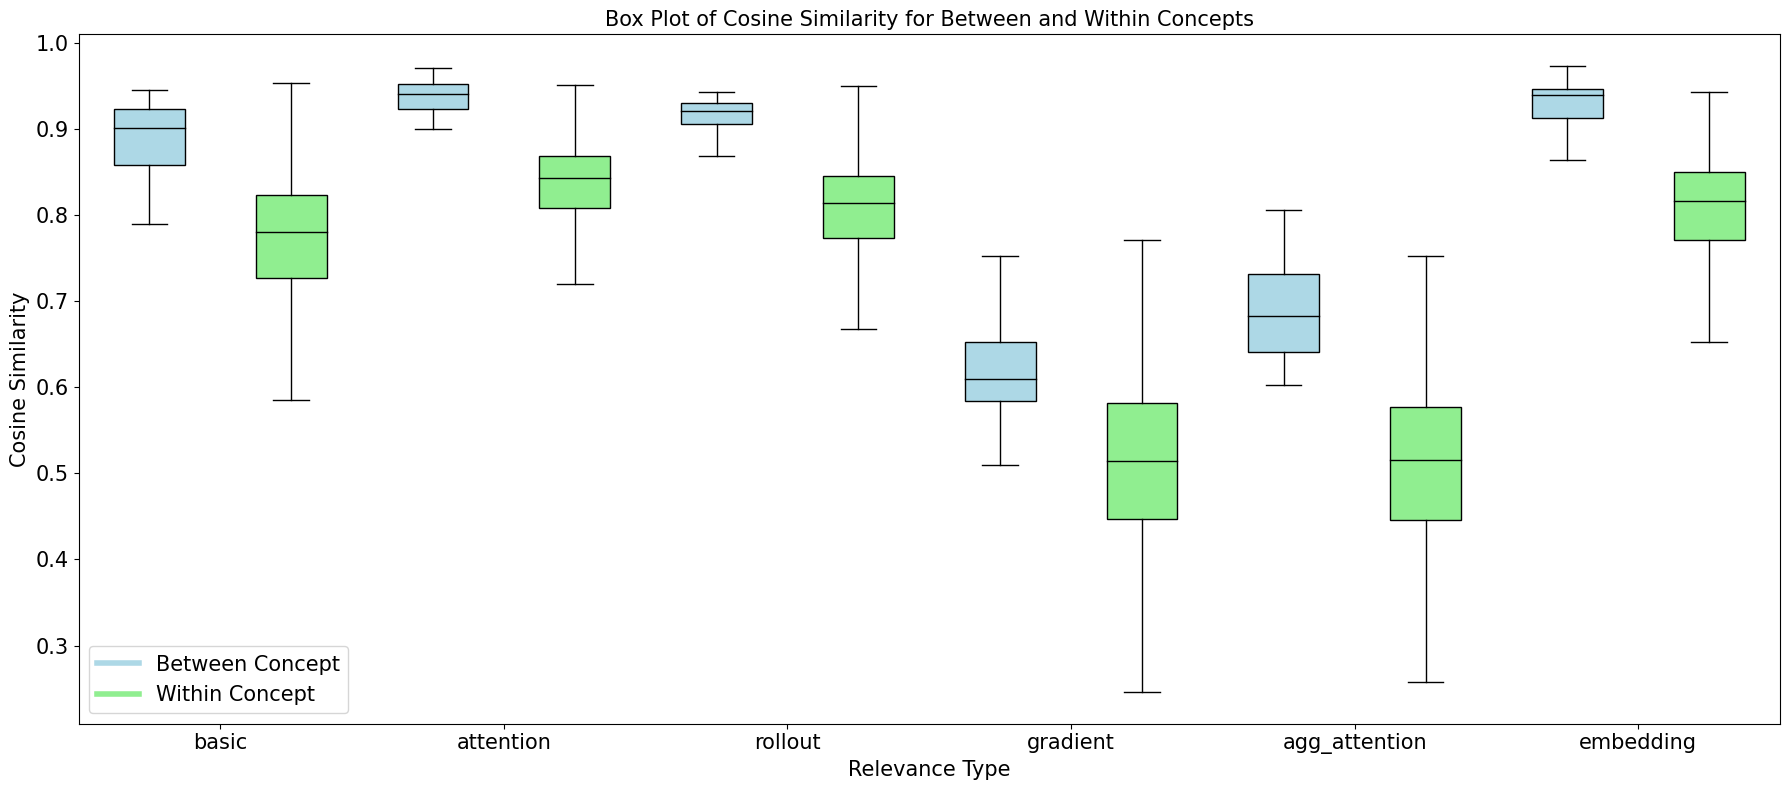

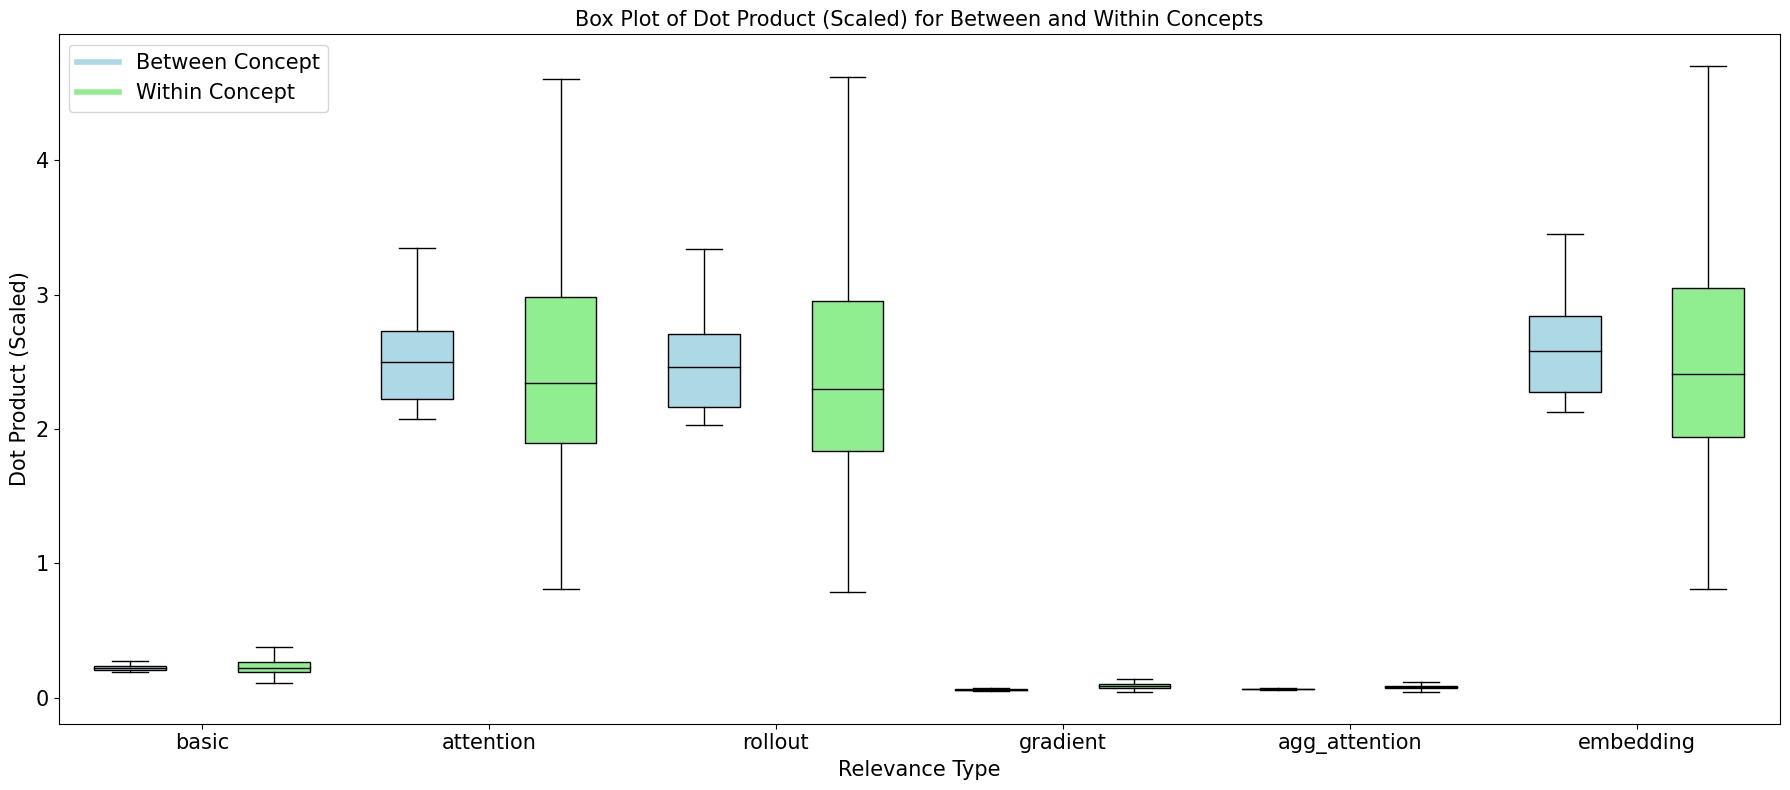

In [201]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def create_combined_box_plots_no_outliers(nearest_df, within_df, output_path):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Define the list of metrics and their display names
    metrics = {
        'sse_scaled': 'SSE (Scaled)',
        'cosine': 'Cosine Similarity',
        'dot_scaled': 'Dot Product (Scaled)'
    }
    
    # Define the relevance types in a consistent order
    relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]
    
    # Define the colors
    nearest_color = 'lightblue'
    within_color = 'lightgreen'

    # Loop through each metric and create combined box plots
    for metric, display_name in metrics.items():
        # Filter the DataFrames for the current metric
        nearest_metric_df = nearest_df[nearest_df['metric'] == metric]
        within_metric_df = within_df[within_df['metric'] == metric]
        
        # Prepare the data for plotting
        data_to_plot = []
        box_colors = []
        
        for relevance in relevance_types:
            # Collect data for nearest and within concept
            nearest_data = nearest_metric_df[nearest_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            within_data = within_metric_df[within_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            
            # Append data and colors
            data_to_plot.append(nearest_data)
            box_colors.append(nearest_color)

            data_to_plot.append(within_data)
            box_colors.append(within_color)
        
        # Create the box plot without outliers
        plt.figure(figsize=(18, 8))
        box = plt.boxplot(data_to_plot, patch_artist=True, showfliers=False)
        
        # Customize box colors
        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels
        plt.title(f'Box Plot of {display_name} for Between and Within Concepts', fontsize=15)
        plt.xlabel('Relevance Type', fontsize=15)
        plt.ylabel(f'{display_name}', fontsize=15)
        plt.yticks(fontsize=15)

        # Customize the x-ticks to place relevance type labels between the two box plots
        num_boxes = len(data_to_plot)
        positions = list(range(1, num_boxes + 1))
        new_labels = []
        for relevance in relevance_types:
            new_labels.extend(['', relevance])
        
        plt.xticks(ticks=[(i + (i+1)) / 2 for i in range(1, num_boxes, 2)], labels=relevance_types, fontsize=15)

        # Add legend for the colors
        handles = [
            plt.Line2D([0], [0], color=nearest_color, lw=4, label='Between Concept'),
            plt.Line2D([0], [0], color=within_color, lw=4, label='Within Concept')
        ]
        plt.legend(handles=handles, fontsize=15)

        plt.tight_layout()
        
        # Save and display the plot with '_no_outliers' tag
        plt.savefig(f'{output_path}/combined_boxplot_{metric}_no_outliers.png')
        plt.show()

# Load the CSV files
nearest_csv_path = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'
within_csv_path = 'images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/All_Concepts_Boxplot_data.csv'

nearest_df = pd.read_csv(nearest_csv_path)
within_df = pd.read_csv(within_csv_path)

# Define the output path for the images
output_path = 'images_combined_box_plots'

# Generate the combined box plots without outliers
create_combined_box_plots_no_outliers(nearest_df, within_df, output_path)


### Separate plot for each metric with outliers, y axis clipped for SSE (scaled) and Dot Product (scaled)

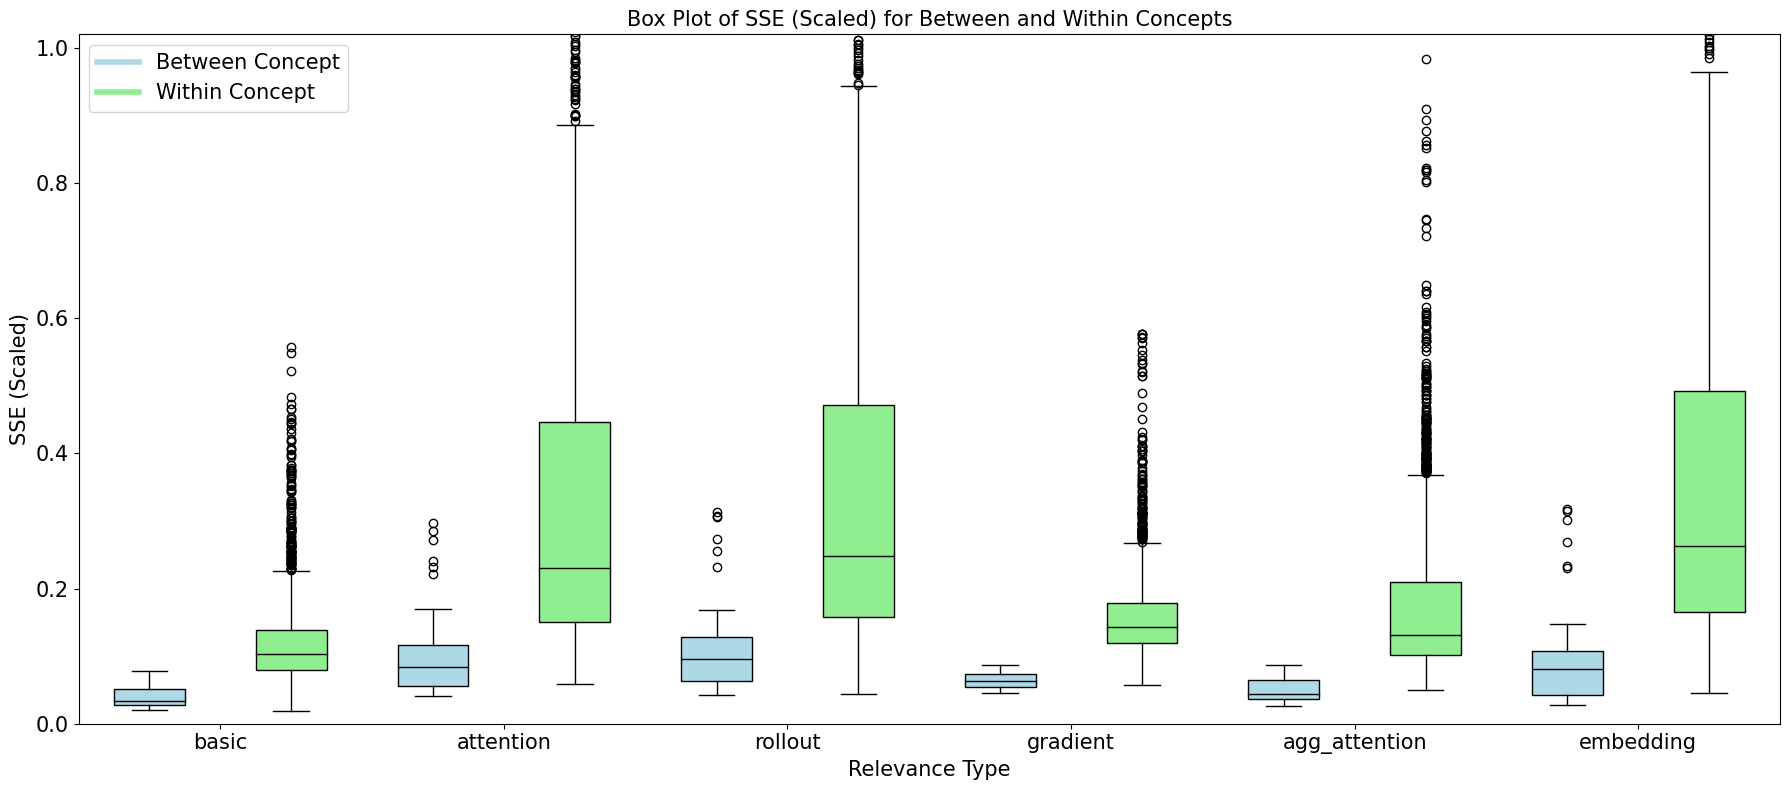

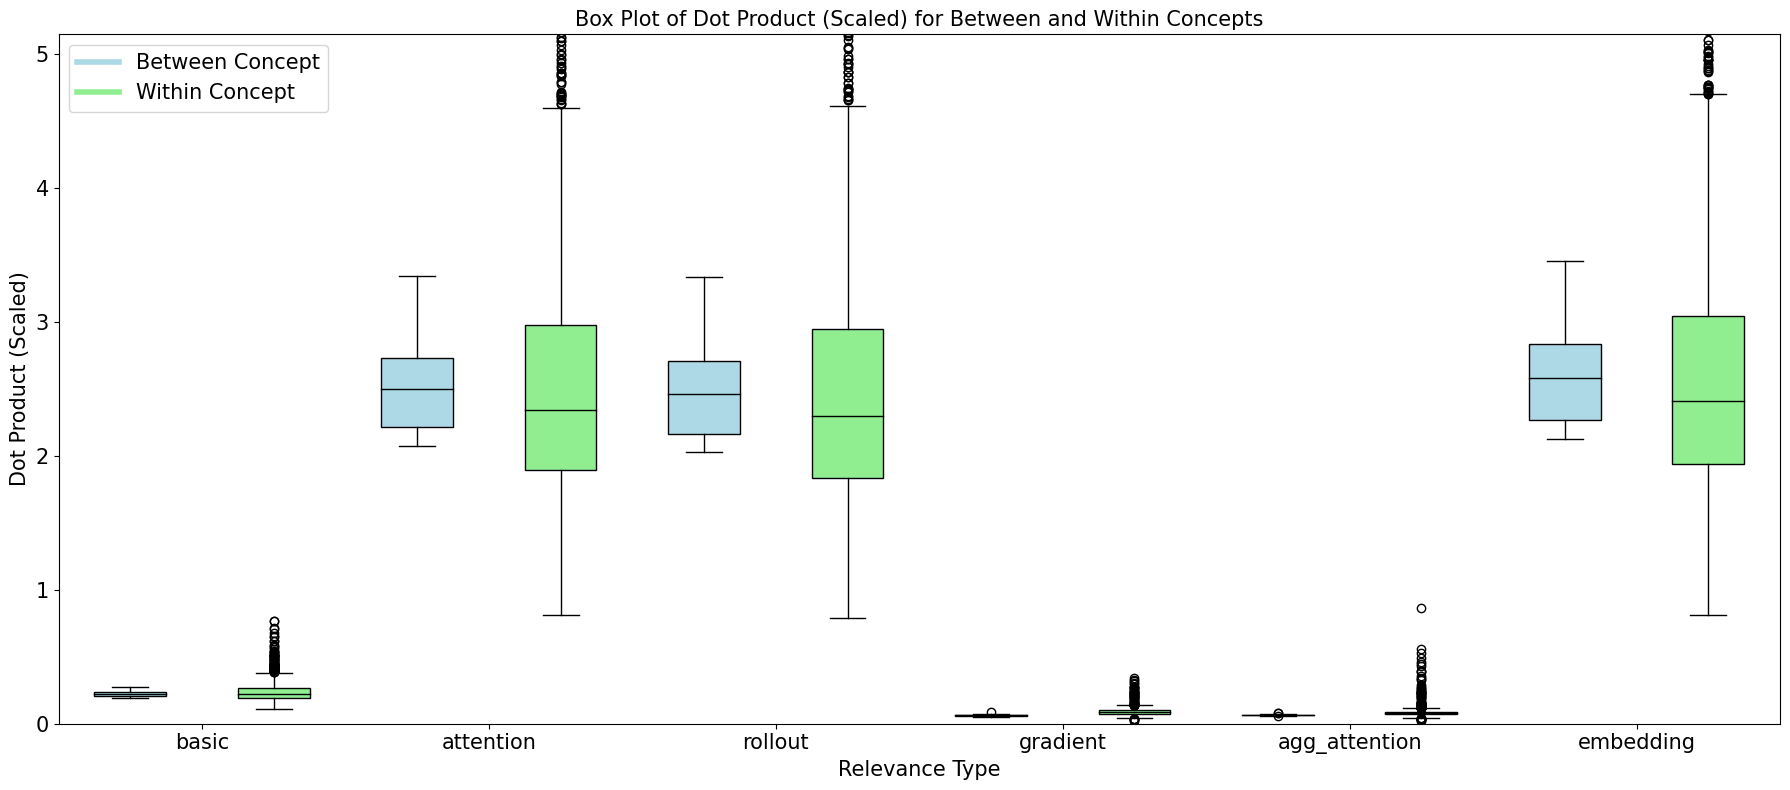

In [202]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def create_combined_box_plots_clipped_yaxis(nearest_df, within_df, output_path):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Define the list of metrics and their display names
    metrics = {
        'sse_scaled': 'SSE (Scaled)',
        'cosine': 'Cosine Similarity',
        'dot_scaled': 'Dot Product (Scaled)'
    }
    
    # Define the relevance types in a consistent order
    relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]
    
    # Define the colors
    nearest_color = 'lightblue'
    within_color = 'lightgreen'

    # Loop through each metric and create combined box plots
    for metric, display_name in metrics.items():
        # Skip processing for the 'cosine' metric
        if metric == 'cosine':
            continue
        
        # Filter the DataFrames for the current metric
        nearest_metric_df = nearest_df[nearest_df['metric'] == metric]
        within_metric_df = within_df[within_df['metric'] == metric]
        
        # Prepare the data for plotting
        data_to_plot = []
        box_colors = []
        for relevance in relevance_types:
            # Collect data for nearest and within concept
            nearest_data = nearest_metric_df[nearest_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            within_data = within_metric_df[within_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            
            # Append data and colors
            data_to_plot.append(nearest_data)
            box_colors.append(nearest_color)

            data_to_plot.append(within_data)
            box_colors.append(within_color)
        
        # Create the box plot
        plt.figure(figsize=(18, 8))
        box = plt.boxplot(data_to_plot, patch_artist=True)
        
        # Customize box colors
        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels
        plt.title(f'Box Plot of {display_name} for Between and Within Concepts', fontsize=15)
        plt.xlabel('Relevance Type', fontsize=15)
        plt.ylabel(f'{display_name}', fontsize=15)
        plt.yticks(fontsize=15)

        # Clip the y-axis based on the metric type and add some space above
        if metric == 'sse_scaled':
            plt.ylim(0, 1.02)  # Set the y-axis limit for SSE (Scaled) with some space above
        elif metric == 'dot_scaled':
            plt.ylim(0, 5.15)  # Set the y-axis limit for Dot Product (Scaled) with some space above
        
        # Customize the x-ticks to place relevance type labels between the two box plots
        num_boxes = len(data_to_plot)
        positions = list(range(1, num_boxes + 1))
        new_labels = []
        for relevance in relevance_types:
            new_labels.extend(['', relevance])
        
        plt.xticks(ticks=[(i + (i+1)) / 2 for i in range(1, num_boxes, 2)], labels=relevance_types, fontsize=15)#, rotation=45)

        # Add legend for the colors
        handles = [
            plt.Line2D([0], [0], color=nearest_color, lw=4, label='Between Concept'),
            plt.Line2D([0], [0], color=within_color, lw=4, label='Within Concept')
        ]
        plt.legend(handles=handles, fontsize=15)

        plt.tight_layout()
        
        # Save and display the plot
        plt.savefig(f'{output_path}/combined_boxplot_{metric}_clipped_yaxis.png')
        plt.show()


# Load the CSV files
nearest_csv_path = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'
within_csv_path = 'images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/All_Concepts_Boxplot_data.csv'

nearest_df = pd.read_csv(nearest_csv_path)
within_df = pd.read_csv(within_csv_path)

# Define the output path for the images
output_path = 'images_combined_box_plots'

# Generate the combined box plots with clipped y-axis for SSE (Scaled) and Dot Product (Scaled)
create_combined_box_plots_clipped_yaxis(nearest_df, within_df, output_path)


### Combined side-by-side plot for all metrics with outliers

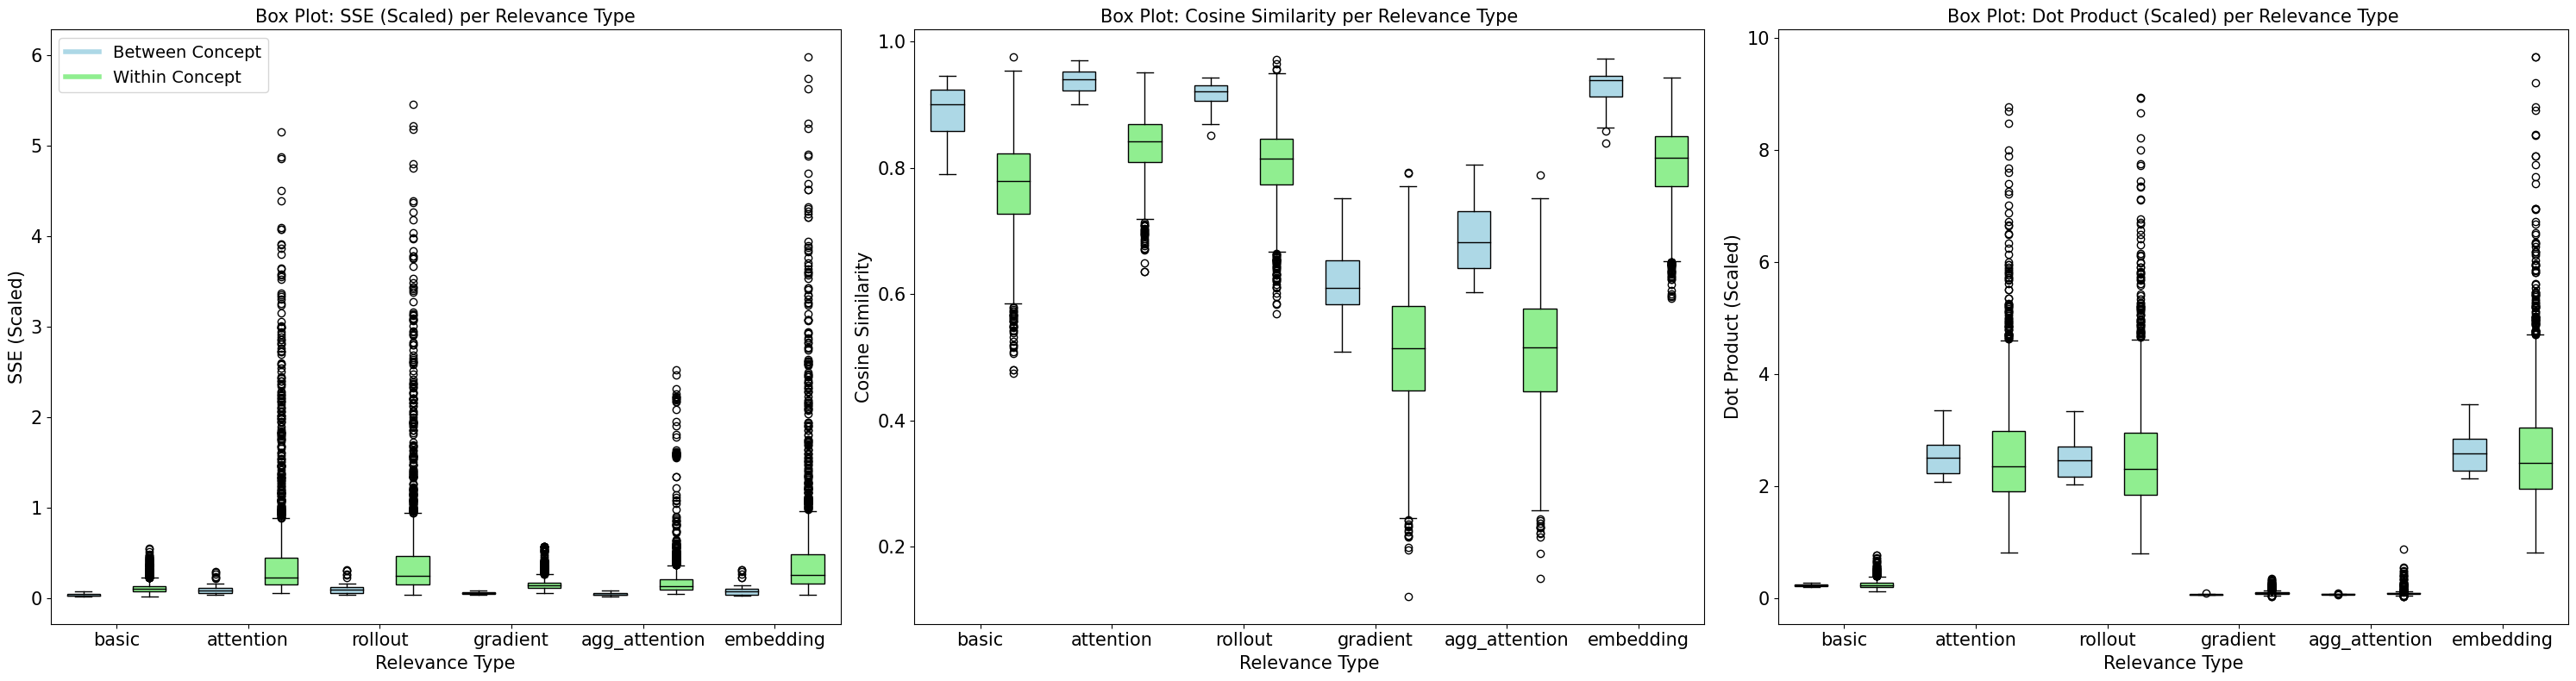

In [212]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def create_combined_box_plots_side_by_side(nearest_df, within_df, output_path):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Define the list of metrics and their display names
    metrics = {
        'sse_scaled': 'SSE (Scaled)',
        'cosine': 'Cosine Similarity',
        'dot_scaled': 'Dot Product (Scaled)'
    }
    
    # Define the relevance types in a consistent order
    relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]
    
    # Define the colors
    nearest_color = 'lightblue'
    within_color = 'lightgreen'

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))  # Increase width to accommodate all plots

    for i, (metric, display_name) in enumerate(metrics.items()):
        ax = axes[i]
        
        # Filter the DataFrames for the current metric
        nearest_metric_df = nearest_df[nearest_df['metric'] == metric]
        within_metric_df = within_df[within_df['metric'] == metric]
        
        # Prepare the data for plotting
        data_to_plot = []
        box_colors = []
        
        for relevance in relevance_types:
            # Collect data for nearest and within concept
            nearest_data = nearest_metric_df[nearest_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            within_data = within_metric_df[within_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            
            # Append data and colors
            data_to_plot.append(nearest_data)
            box_colors.append(nearest_color)

            data_to_plot.append(within_data)
            box_colors.append(within_color)
        
        # Create the box plot
        box = ax.boxplot(data_to_plot, patch_artist=True)
        
        # Customize box colors
        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels
        ax.set_title(f'Box Plot: {display_name} per Relevance Type', fontsize=15)
        ax.set_xlabel('Relevance Type', fontsize=15)
        ax.set_ylabel(f'{display_name}', fontsize=15)# if i == 0 else 0)  # Set y-label only for the first plot
        ax.tick_params(axis='y', labelsize=15)

        # Customize the x-ticks to place relevance type labels between the two box plots
        num_boxes = len(data_to_plot)
        positions = list(range(1, num_boxes + 1))
        midpoint_positions = [(positions[j] + positions[j + 1]) / 2 for j in range(0, len(positions), 2)]

        ax.set_xticks(midpoint_positions)
        ax.set_xticklabels(relevance_types, fontsize=15) #, rotation=45)

        # Add legend for the colors
        if i == 0:  # Add legend only on the first plot
            handles = [
                plt.Line2D([0], [0], color=nearest_color, lw=4, label='Between Concept'),
                plt.Line2D([0], [0], color=within_color, lw=4, label='Within Concept')
            ]
            ax.legend(handles=handles, fontsize=14)

    plt.tight_layout()
    
    # Save the combined figure
    plt.savefig(f'{output_path}/combined_boxplot_all_metrics_side_by_side.png')
    plt.show()

# Load the CSV files
nearest_csv_path = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'
within_csv_path = 'images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/All_Concepts_Boxplot_data.csv'

nearest_df = pd.read_csv(nearest_csv_path)
within_df = pd.read_csv(within_csv_path)

# Define the output path for the images
# output_path = 'images_combined_box_plots/size18/'
output_path = 'images_combined_box_plots/'

# Generate the combined box plots
create_combined_box_plots_side_by_side(nearest_df, within_df, output_path)


### Combined side-by-side plot for all metrics without outliers

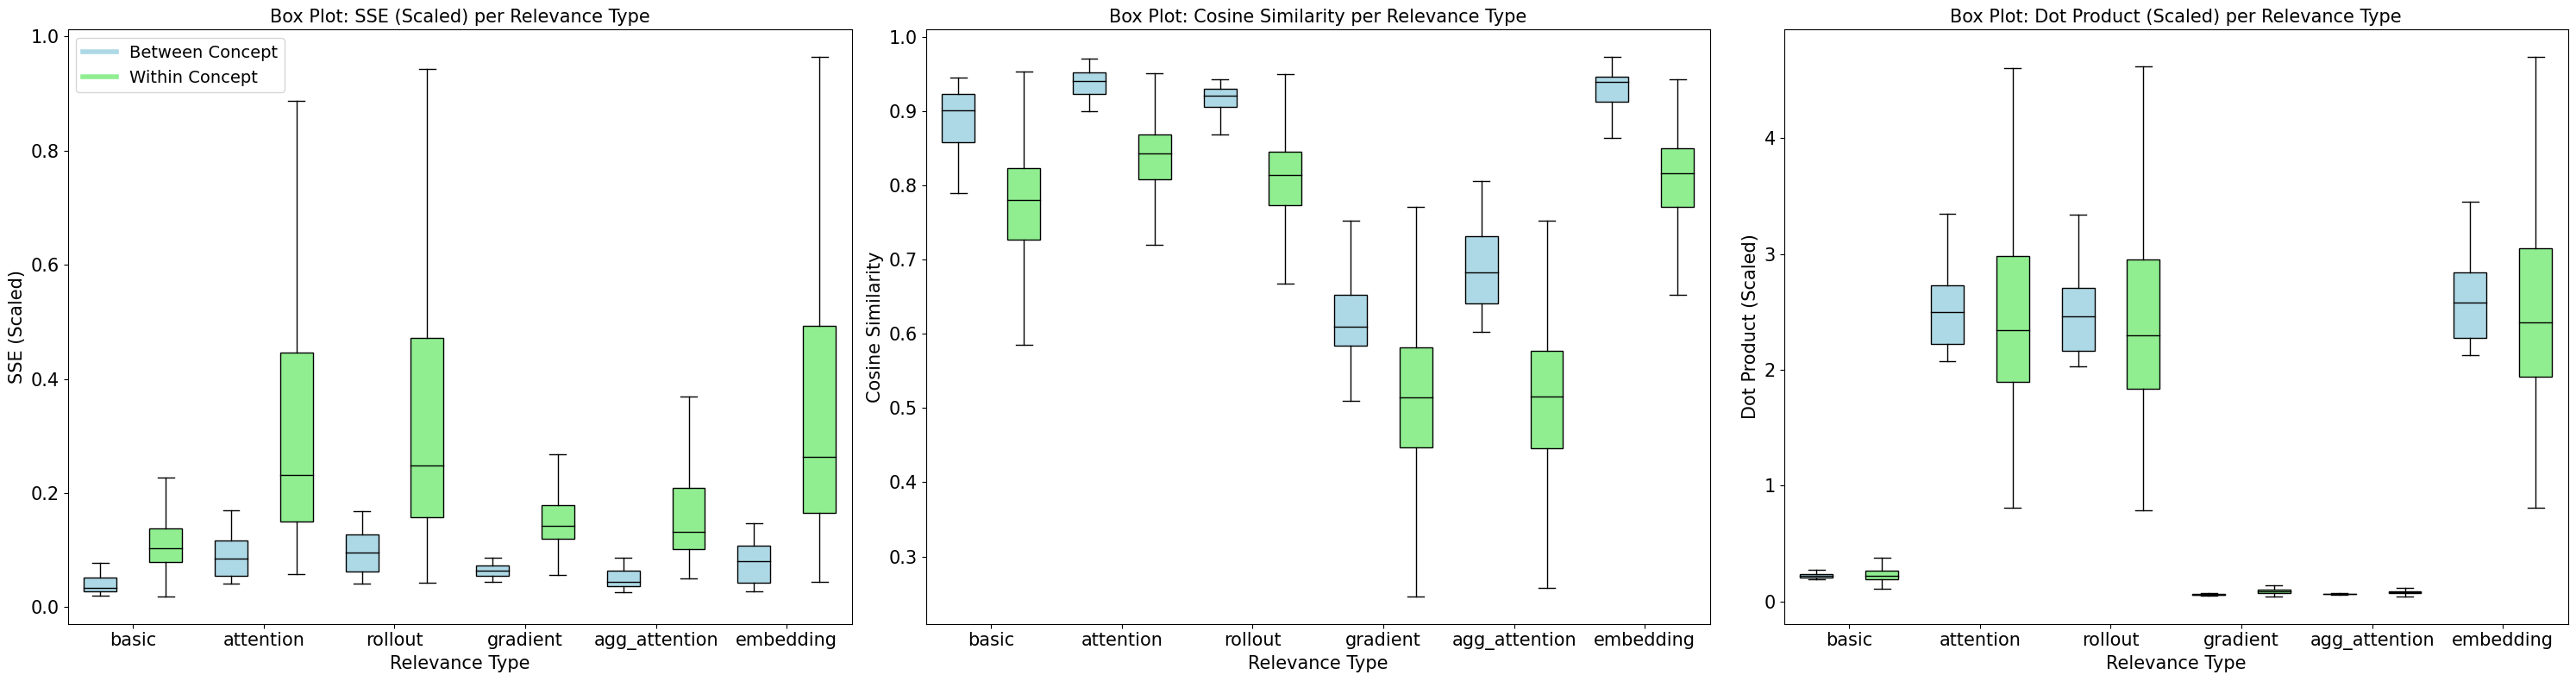

In [214]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def create_combined_box_plots_side_by_side_no_outliers(nearest_df, within_df, output_path):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Define the list of metrics and their display names
    metrics = {
        'sse_scaled': 'SSE (Scaled)',
        'cosine': 'Cosine Similarity',
        'dot_scaled': 'Dot Product (Scaled)'
    }
    
    # Define the relevance types in a consistent order
    relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]
    
    # Define the colors
    nearest_color = 'lightblue'
    within_color = 'lightgreen'

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))  # Increase width to accommodate all plots

    for i, (metric, display_name) in enumerate(metrics.items()):
        ax = axes[i]
        
        # Filter the DataFrames for the current metric
        nearest_metric_df = nearest_df[nearest_df['metric'] == metric]
        within_metric_df = within_df[within_df['metric'] == metric]
        
        # Prepare the data for plotting
        data_to_plot = []
        box_colors = []
        
        for relevance in relevance_types:
            # Collect data for nearest and within concept
            nearest_data = nearest_metric_df[nearest_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            within_data = within_metric_df[within_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            
            # Append data and colors
            data_to_plot.append(nearest_data)
            box_colors.append(nearest_color)

            data_to_plot.append(within_data)
            box_colors.append(within_color)
        
        # Create the box plot without outliers
        box = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
        
        # Customize box colors
        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels
        ax.set_title(f'Box Plot: {display_name} per Relevance Type', fontsize=15)
        ax.set_xlabel('Relevance Type', fontsize=15)
        ax.set_ylabel(f'{display_name}', fontsize=15)  # Set y-label
        ax.tick_params(axis='y', labelsize=15)

        # Customize the x-ticks to place relevance type labels between the two box plots
        num_boxes = len(data_to_plot)
        positions = list(range(1, num_boxes + 1))
        midpoint_positions = [(positions[j] + positions[j + 1]) / 2 for j in range(0, len(positions), 2)]

        ax.set_xticks(midpoint_positions)
        ax.set_xticklabels(relevance_types, fontsize=15) #, rotation=45)

        # Add legend for the colors
        if i == 0:  # Add legend only on the first plot
            handles = [
                plt.Line2D([0], [0], color=nearest_color, lw=4, label='Between Concept'),
                plt.Line2D([0], [0], color=within_color, lw=4, label='Within Concept')
            ]
            ax.legend(handles=handles, fontsize=14) #, loc='upper left')

    plt.tight_layout()
    
    # Save the combined figure with "_no_outliers" in the file name
    plt.savefig(f'{output_path}/combined_boxplot_all_metrics_side_by_side_no_outliers.png')
    plt.show()

# Load the CSV files
nearest_csv_path = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'
within_csv_path = 'images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/All_Concepts_Boxplot_data.csv'

nearest_df = pd.read_csv(nearest_csv_path)
within_df = pd.read_csv(within_csv_path)

# Define the output path for the images
# output_path = 'images_combined_box_plots/size18/'
output_path = 'images_combined_box_plots/'

# Generate the combined box plots without outliers
create_combined_box_plots_side_by_side_no_outliers(nearest_df, within_df, output_path)


### Combined side-by-side plot for all metrics with outliers, Clipped y-axis for SSE (scaled), Dot Product (scaled)

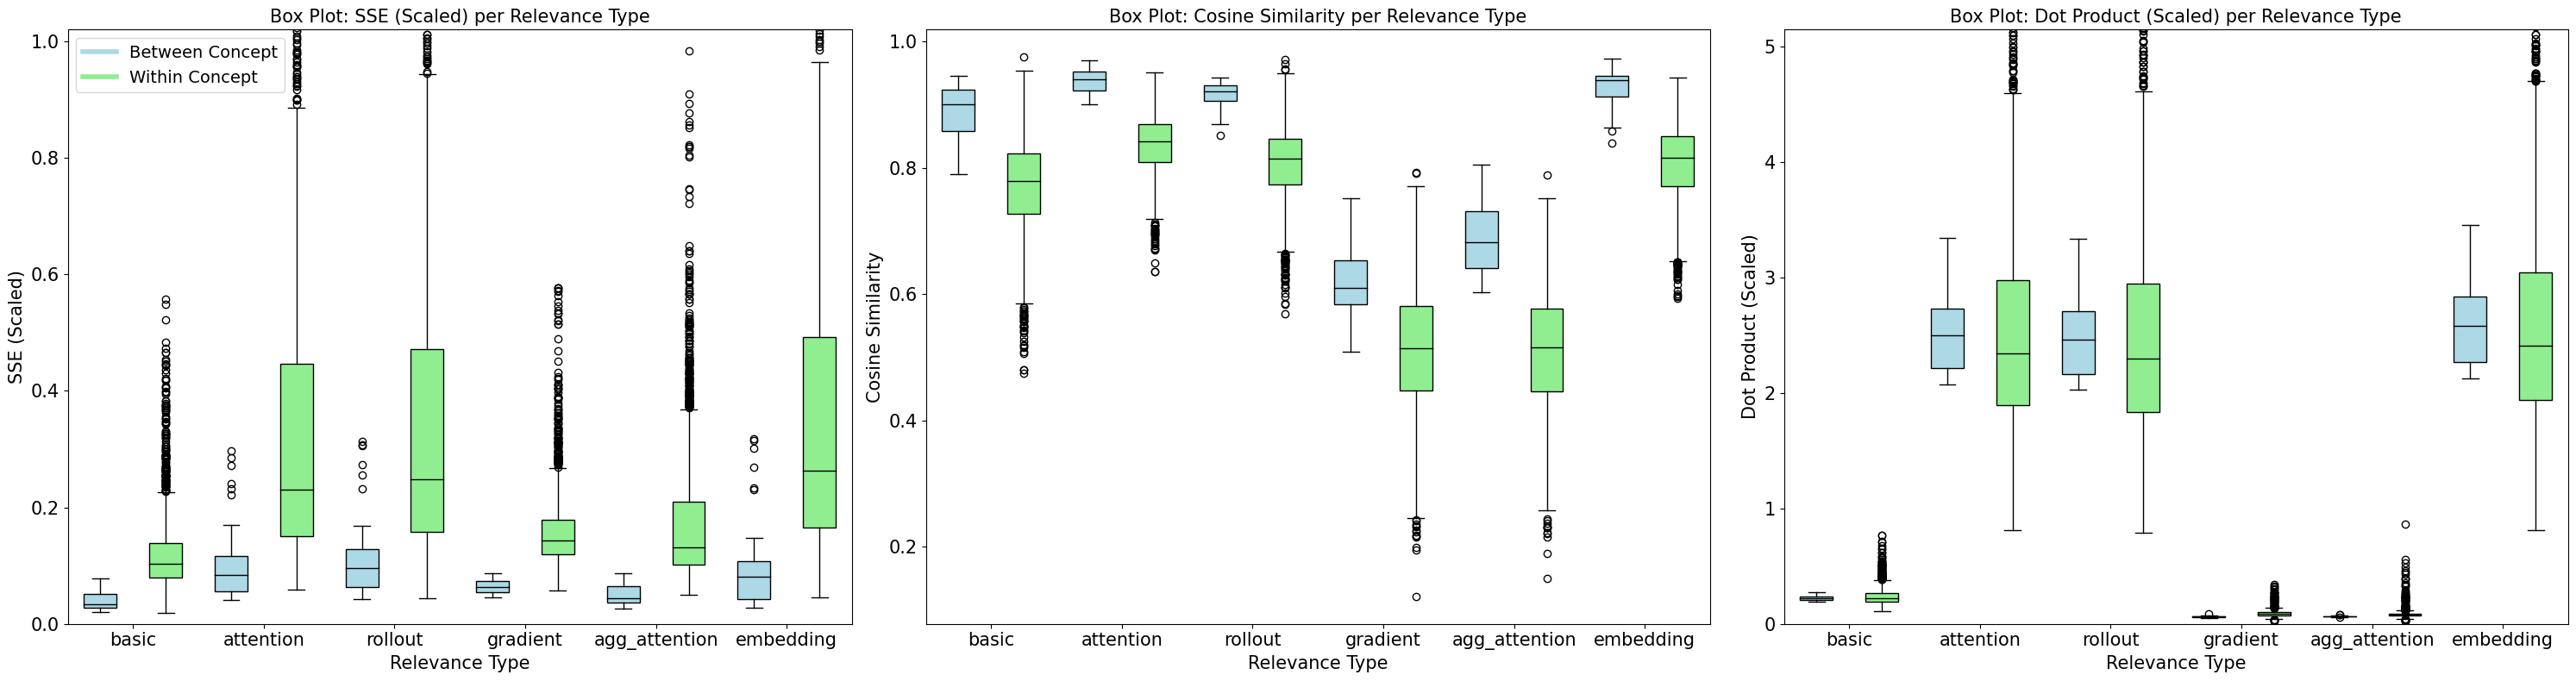

In [215]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def create_combined_box_plots_clipped_yaxis_side_by_side(nearest_df, within_df, output_path):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Define the list of metrics and their display names
    metrics = {
        'sse_scaled': 'SSE (Scaled)',
        'cosine': 'Cosine Similarity',
        'dot_scaled': 'Dot Product (Scaled)'
    }
    
    # Define the relevance types in a consistent order
    relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]
    
    # Define the colors
    nearest_color = 'lightblue'
    within_color = 'lightgreen'

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))  # Increase width to accommodate all plots

    for i, (metric, display_name) in enumerate(metrics.items()):
        ax = axes[i]
        
        # Filter the DataFrames for the current metric
        nearest_metric_df = nearest_df[nearest_df['metric'] == metric]
        within_metric_df = within_df[within_df['metric'] == metric]
        
        # Prepare the data for plotting
        data_to_plot = []
        box_colors = []
        
        for relevance in relevance_types:
            # Collect data for nearest and within concept
            nearest_data = nearest_metric_df[nearest_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            within_data = within_metric_df[within_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            
            # Append data and colors
            data_to_plot.append(nearest_data)
            box_colors.append(nearest_color)

            data_to_plot.append(within_data)
            box_colors.append(within_color)
        
        # Create the box plot
        box = ax.boxplot(data_to_plot, patch_artist=True)
        
        # Customize box colors
        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels
        ax.set_title(f'Box Plot: {display_name} per Relevance Type', fontsize=15)
        ax.set_xlabel('Relevance Type', fontsize=15)
        ax.set_ylabel(f'{display_name}', fontsize=15)  # Set y-label
        ax.tick_params(axis='y', labelsize=15)

        # Clip the y-axis based on the metric type and add some space above
        if metric == 'sse_scaled':
            ax.set_ylim(0, 1.02)  # Set the y-axis limit for SSE (Scaled) with some space above
        elif metric == 'dot_scaled':
            ax.set_ylim(0, 5.15)  # Set the y-axis limit for Dot Product (Scaled) with some space above

        # Customize the x-ticks to place relevance type labels between the two box plots
        num_boxes = len(data_to_plot)
        positions = list(range(1, num_boxes + 1))
        midpoint_positions = [(positions[j] + positions[j + 1]) / 2 for j in range(0, len(positions), 2)]

        ax.set_xticks(midpoint_positions)
        ax.set_xticklabels(relevance_types, fontsize=15) #, rotation=45)

        # Add legend for the colors
        if i == 0:  # Add legend only on the first plot
            handles = [
                plt.Line2D([0], [0], color=nearest_color, lw=4, label='Between Concept'),
                plt.Line2D([0], [0], color=within_color, lw=4, label='Within Concept')
            ]
            ax.legend(handles=handles, fontsize=14) #, loc='upper left')

    plt.tight_layout()
    
    # Save the combined figure with the '_side_by_side' tag
    plt.savefig(f'{output_path}/combined_boxplot_all_metrics_side_by_side_clipped_yaxis.png')
    plt.show()

# Load the CSV files
nearest_csv_path = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'
within_csv_path = 'images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/All_Concepts_Boxplot_data.csv'

nearest_df = pd.read_csv(nearest_csv_path)
within_df = pd.read_csv(within_csv_path)

# Define the output path for the images
# output_path = 'images_combined_box_plots/size18/'
output_path = 'images_combined_box_plots/'

# Generate the combined box plots with clipped y-axis for SSE (Scaled) and Dot Product (Scaled)
create_combined_box_plots_clipped_yaxis_side_by_side(nearest_df, within_df, output_path)


### Combined side-by-side plot for all metrics with outliers: Find image pairs where sse_scaled > 1 and remove them from dataset --> generate plot again   }--> IQR expected to shift downwards

In [218]:
import pandas as pd

def filter_sse_scaled_greater_than_one(within_csv_path):
    # Read the CSV into a DataFrame
    df = pd.read_csv(within_csv_path)

    # Identify the rows where 'sse_scaled' > 1
    rows_to_remove = df[(df['metric'] == 'sse_scaled') & (df['avg_metric_over_layers'] > 1)]

    # Create a list of tuples for the concept_num and image_pair that need to be removed
    pairs_to_remove = sorted(list(set(zip(rows_to_remove['concept_num'], rows_to_remove['image_pair']))))
    print(pairs_to_remove)

    # Filter the DataFrame to remove rows with matching concept_num and image_pair
    df_filtered = df[~df[['concept_num', 'image_pair']].apply(tuple, axis=1).isin(pairs_to_remove)]

    # Write the result DataFrame into a new CSV in the same path
    new_csv_path = within_csv_path.replace('.csv', '_filtered.csv')
    df_filtered.to_csv(new_csv_path, index=False)

    print(f"Filtered DataFrame saved to: {new_csv_path}")

# Example usage
within_csv_path = 'images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/All_Concepts_Boxplot_data.csv'
filter_sse_scaled_greater_than_one(within_csv_path)


[(0, '(1, 5)'), (2, '(0, 1)'), (2, '(0, 10)'), (2, '(0, 11)'), (2, '(0, 12)'), (2, '(0, 14)'), (2, '(0, 15)'), (2, '(0, 16)'), (2, '(0, 17)'), (2, '(0, 18)'), (2, '(0, 19)'), (2, '(0, 2)'), (2, '(0, 3)'), (2, '(0, 5)'), (2, '(0, 6)'), (2, '(0, 7)'), (2, '(0, 8)'), (2, '(1, 9)'), (2, '(12, 15)'), (2, '(13, 15)'), (2, '(3, 9)'), (2, '(4, 15)'), (2, '(5, 9)'), (2, '(6, 9)'), (2, '(7, 9)'), (2, '(9, 10)'), (2, '(9, 15)'), (2, '(9, 16)'), (2, '(9, 17)'), (2, '(9, 18)'), (2, '(9, 19)'), (3, '(0, 1)'), (3, '(0, 12)'), (3, '(0, 13)'), (3, '(0, 14)'), (3, '(0, 15)'), (3, '(0, 2)'), (3, '(1, 10)'), (3, '(1, 11)'), (3, '(1, 16)'), (3, '(1, 17)'), (3, '(1, 18)'), (3, '(1, 19)'), (3, '(1, 3)'), (3, '(1, 4)'), (3, '(1, 5)'), (3, '(1, 6)'), (3, '(1, 7)'), (3, '(1, 8)'), (3, '(1, 9)'), (3, '(10, 12)'), (3, '(10, 13)'), (3, '(10, 14)'), (3, '(11, 12)'), (3, '(11, 13)'), (3, '(11, 14)'), (3, '(11, 15)'), (3, '(12, 16)'), (3, '(12, 17)'), (3, '(12, 18)'), (3, '(12, 19)'), (3, '(13, 16)'), (3, '(13, 17)')

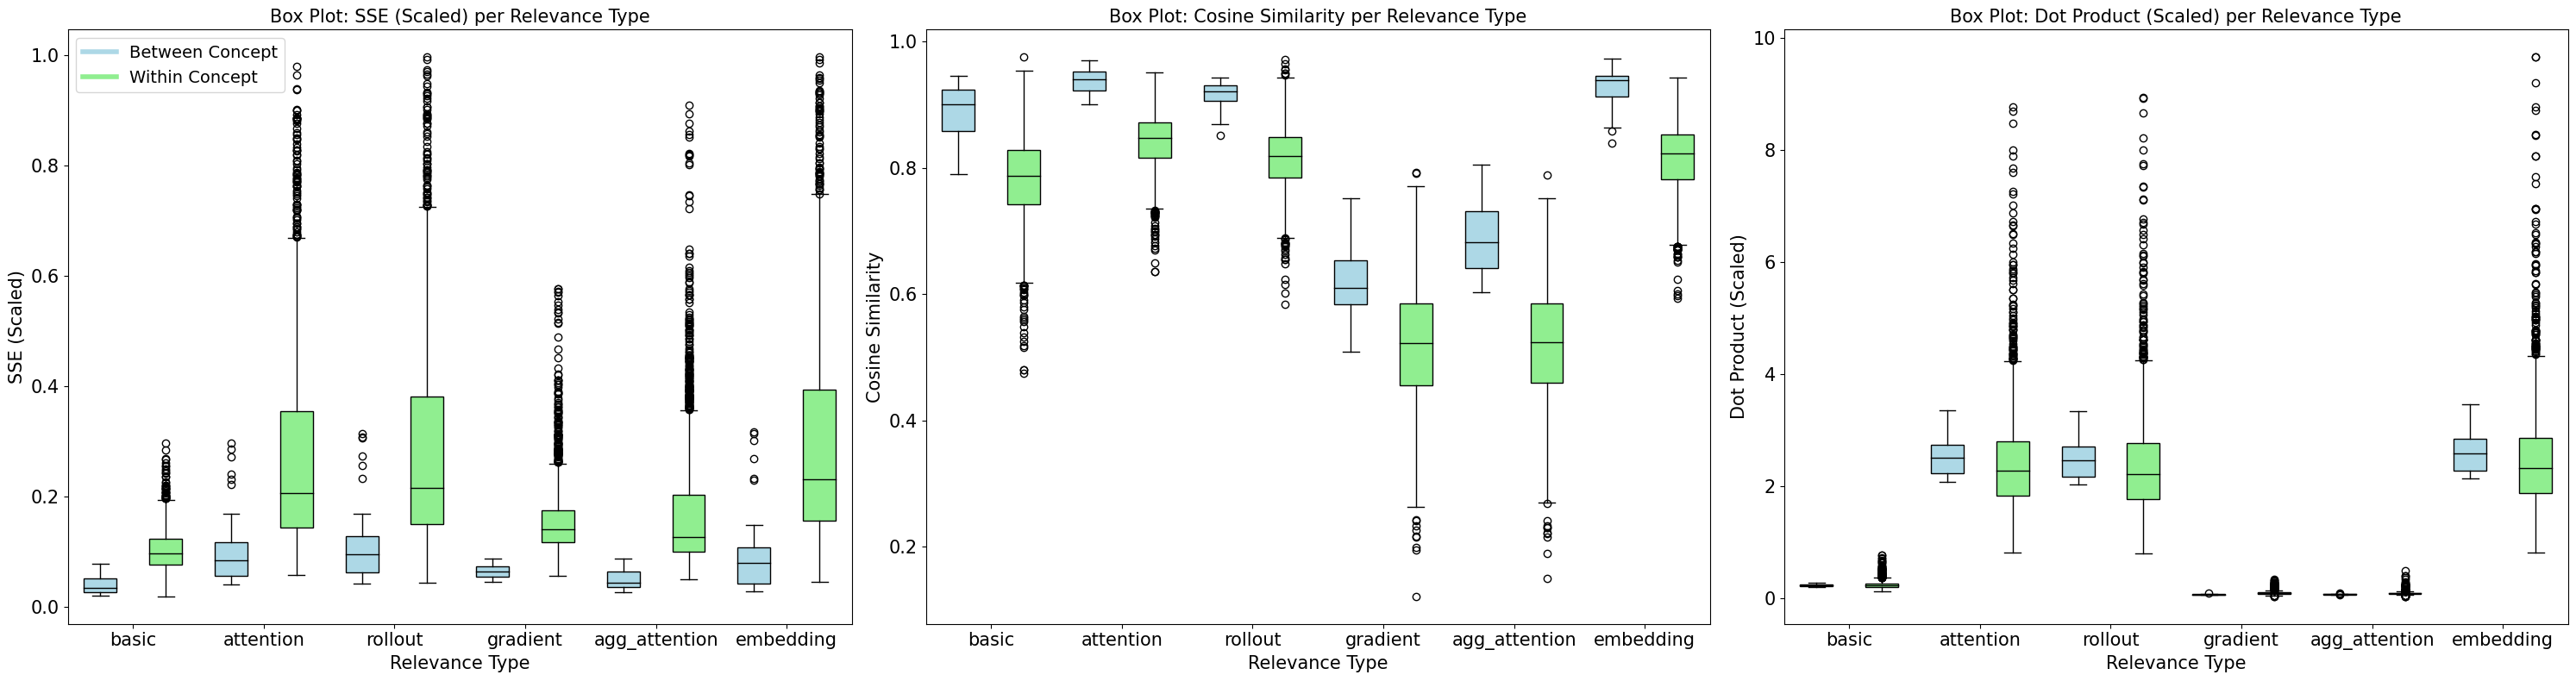

In [219]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def create_combined_box_plots_side_by_side(nearest_df, within_df, output_path):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Define the list of metrics and their display names
    metrics = {
        'sse_scaled': 'SSE (Scaled)',
        'cosine': 'Cosine Similarity',
        'dot_scaled': 'Dot Product (Scaled)'
    }
    
    # Define the relevance types in a consistent order
    relevance_types = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]
    
    # Define the colors
    nearest_color = 'lightblue'
    within_color = 'lightgreen'

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))  # Increase width to accommodate all plots

    for i, (metric, display_name) in enumerate(metrics.items()):
        ax = axes[i]
        
        # Filter the DataFrames for the current metric
        nearest_metric_df = nearest_df[nearest_df['metric'] == metric]
        within_metric_df = within_df[within_df['metric'] == metric]
        
        # Prepare the data for plotting
        data_to_plot = []
        box_colors = []
        
        for relevance in relevance_types:
            # Collect data for nearest and within concept
            nearest_data = nearest_metric_df[nearest_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            within_data = within_metric_df[within_metric_df['relevance_type'] == relevance]['avg_metric_over_layers'].values
            
            # Append data and colors
            data_to_plot.append(nearest_data)
            box_colors.append(nearest_color)

            data_to_plot.append(within_data)
            box_colors.append(within_color)
        
        # Create the box plot
        box = ax.boxplot(data_to_plot, patch_artist=True)
        
        # Customize box colors
        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)

        # Set the color of the median line to black
        for median in box['medians']:
            median.set_color('black')

        # Set titles and labels
        ax.set_title(f'Box Plot: {display_name} per Relevance Type', fontsize=15)
        ax.set_xlabel('Relevance Type', fontsize=15)
        ax.set_ylabel(f'{display_name}', fontsize=15)# if i == 0 else 0)  # Set y-label only for the first plot
        ax.tick_params(axis='y', labelsize=15)

        # Customize the x-ticks to place relevance type labels between the two box plots
        num_boxes = len(data_to_plot)
        positions = list(range(1, num_boxes + 1))
        midpoint_positions = [(positions[j] + positions[j + 1]) / 2 for j in range(0, len(positions), 2)]

        ax.set_xticks(midpoint_positions)
        ax.set_xticklabels(relevance_types, fontsize=15) #, rotation=45)

        # Add legend for the colors
        if i == 0:  # Add legend only on the first plot
            handles = [
                plt.Line2D([0], [0], color=nearest_color, lw=4, label='Between Concept'),
                plt.Line2D([0], [0], color=within_color, lw=4, label='Within Concept')
            ]
            ax.legend(handles=handles, fontsize=14)

    plt.tight_layout()
    
    # Save the combined figure
    plt.savefig(f'{output_path}/combined_boxplot_all_metrics_side_by_side_filtered.png')
    plt.show()

# Load the CSV files
nearest_csv_path = 'images_nearest_concept_pipeline/K_value_50/concept_metrics_all_K_50.csv'
within_csv_path = 'images_within_concept_pipeline/K_value_50/All_Concepts_Box_Plots/All_Concepts_Boxplot_data_filtered.csv'

nearest_df = pd.read_csv(nearest_csv_path)
within_df = pd.read_csv(within_csv_path)

# Define the output path for the images
# output_path = 'images_combined_box_plots/size18/'
output_path = 'images_combined_box_plots/'

# Generate the combined box plots
create_combined_box_plots_side_by_side(nearest_df, within_df, output_path)
